In [1]:
# Import libraries and modules
import sys
import tensorflow as tf
import numpy as np
import shutil
print(tf.__version__)
print(np.__version__)
np.set_printoptions(threshold = np.inf)

1.13.1
1.16.2


In [2]:
# !pip install tensorflow==1.12.0

In [3]:
# tf.enable_eager_execution()
tf.executing_eagerly()

False

In [4]:
# import os
# BUCKET = 'qwiklabs-gcp-8923d4964bfbd247-bucket' # REPLACE WITH A BUCKET NAME (PUT YOUR PROJECT ID AND WE CREATE THE BUCKET ITSELF NEXT)
# PROJECT = 'qwiklabs-gcp-8923d4964bfbd247' # REPLACE WITH YOUR PROJECT ID
# REGION = 'us-central1' # REPLACE WITH YOUR REGION e.g. us-central1

# # Import os environment variables
# os.environ['PROJECT'] = PROJECT
# os.environ['BUCKET'] =  BUCKET
# os.environ['REGION'] = REGION
# os.environ['TFVERSION'] = '1.8'

# Create data

## Create data generator

In [5]:
percent_sequence_before_anomaly = 70.0
percent_sequence_after_anomaly = 0.0

def create_time_series_normal_parameters():
    normal_frequency_noise_scale = 1.0
    normal_frequence_noise_shift = 1.0

    normal_amplitude_noise_scale = 1.0
    normal_amplitude_noise_shift = 1.0

    normal_noise_noise_scale = 1.0

    normal_freq = (np.random.random() * normal_frequency_noise_scale) + normal_frequence_noise_shift
    normal_ampl = np.random.random() * normal_amplitude_noise_scale + normal_amplitude_noise_shift

    return {"normal_freq": normal_freq, "normal_ampl": normal_ampl, "normal_noise_noise_scale": normal_noise_noise_scale}
  

def create_time_series_normal(number_of_sequences, sequence_length, normal_freq, normal_ampl, normal_noise_noise_scale):
    # Normal parameters
    sequence = np.stack(arrays = [np.sin(np.arange(0, sequence_length) * normal_freq) * normal_ampl + [np.random.random() * normal_noise_noise_scale for i in range(sequence_length)] for _ in range(number_of_sequences)], axis = 0)

    return sequence

def create_time_series_with_anomaly(number_of_sequences, sequence_length, percent_sequence_before_anomaly, percent_sequence_after_anomaly, normal_freq, normal_ampl, normal_noise_noise_scale):
    sequence_length_before_anomaly = int(sequence_length * percent_sequence_before_anomaly / 100.0)
    sequence_length_after_anomaly = int(sequence_length * percent_sequence_after_anomaly / 100.0)
    sequence_length_anomaly = sequence_length - sequence_length_before_anomaly - sequence_length_after_anomaly

    # Anomalous parameters
    anomalous_amplitude_multipler_min = 5.0
    anomalous_amplitude_multipler_max = 10.0

    sequence_with_anomaly = create_time_series_normal(number_of_sequences, sequence_length, normal_freq, normal_ampl, normal_noise_noise_scale)
    
    sequence_with_anomaly[:, sequence_length_before_anomaly:sequence_length_before_anomaly + sequence_length_anomaly] *= ((anomalous_amplitude_multipler_max - anomalous_amplitude_multipler_min) * np.random.random_sample([number_of_sequences, sequence_length_anomaly]) + anomalous_amplitude_multipler_min) * (np.random.randint(2, size = [number_of_sequences, sequence_length_anomaly]) * -2 + 1)
    
    return sequence_with_anomaly

In [6]:
test_normal_parameters = create_time_series_normal_parameters()

/usr/local/lib/python3.5/dist-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


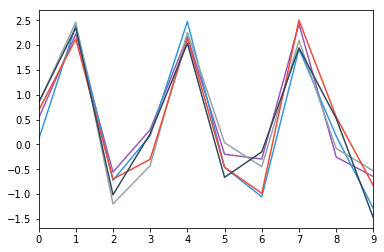

In [7]:
import seaborn as sns
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
for i in range(0, 5):
    sns.tsplot(create_time_series_normal(1, 10, test_normal_parameters["normal_freq"], test_normal_parameters["normal_ampl"], test_normal_parameters["normal_noise_noise_scale"]).reshape(-1), color=flatui[i%len(flatui)] )

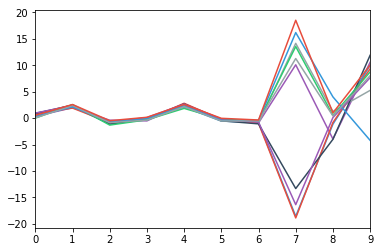

In [8]:
import seaborn as sns
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
for i in range(0, 10):
    sns.tsplot(create_time_series_with_anomaly(1, 10, percent_sequence_before_anomaly, percent_sequence_after_anomaly, test_normal_parameters["normal_freq"], test_normal_parameters["normal_ampl"], test_normal_parameters["normal_noise_noise_scale"]).reshape(-1), color=flatui[i%len(flatui)] )

## Create training and evaluation data

In [9]:
number_of_training_normal_sequences = 64000

number_of_validation_normal_1_sequences = 6400
number_of_validation_normal_2_sequences = 6400
number_of_validation_anomalous_sequences = 6400

number_of_test_normal_sequences = 6400
number_of_test_anomalous_sequences = 6400

sequence_length = 30
number_of_tags = 3
tag_columns = ["tag_{0}".format(tag) for tag in range(0, number_of_tags)]

In [10]:
tag_data_list = [create_time_series_normal_parameters() for tag in range(0, number_of_tags)]
tag_data_list

[{'normal_ampl': 1.171677846827465,
  'normal_freq': 1.638359327798789,
  'normal_noise_noise_scale': 1.0},
 {'normal_ampl': 1.205405519520407,
  'normal_freq': 1.6927725572108985,
  'normal_noise_noise_scale': 1.0},
 {'normal_ampl': 1.2714227324748673,
  'normal_freq': 1.2641840180417858,
  'normal_noise_noise_scale': 1.0}]

In [11]:
# Create training set using normal sequences
training_normal_sequences_list = [create_time_series_normal(number_of_training_normal_sequences, sequence_length, tag["normal_freq"], tag["normal_ampl"], tag["normal_noise_noise_scale"]) for tag in tag_data_list]
training_normal_sequences_array = np.stack(arrays = list(map(lambda i: np.stack(arrays = list(map(lambda j: np.array2string(a = training_normal_sequences_list[i][j], separator = ',').replace('[', '').replace(']', '').replace(' ', '').replace('\n', ''), np.arange(0, number_of_training_normal_sequences))), axis = 0), np.arange(0, number_of_tags))), axis = 1)
np.random.shuffle(training_normal_sequences_array)
print("training_normal_sequences_array.shape = \n{}".format(training_normal_sequences_array.shape))

training_normal_sequences_array.shape = 
(64000, 3)


In [12]:
# Create validation sets
# Create set vn1 of normal sequences which will be used for early stopping during training as well as using the error vectors to learn mu and sigma for mahalanobis distance
validation_normal_1_sequences_list = [create_time_series_normal(number_of_validation_normal_1_sequences, sequence_length, tag["normal_freq"], tag["normal_ampl"], tag["normal_noise_noise_scale"]) for tag in tag_data_list]
validation_normal_1_sequences_array = np.stack(arrays = list(map(lambda i: np.stack(arrays = list(map(lambda j: np.array2string(a = validation_normal_1_sequences_list[i][j], separator = ',').replace('[', '').replace(']', '').replace(' ', '').replace('\n', ''), np.arange(0, number_of_validation_normal_1_sequences))), axis = 0), np.arange(0, number_of_tags))), axis = 1)
print("validation_normal_1_sequences_array.shape = \n{}".format(validation_normal_1_sequences_array.shape))

# Create set vn2 of normal sequences which will be used for tuning the anomaly thresholds
validation_normal_2_sequences_list = [create_time_series_normal(number_of_validation_normal_2_sequences, sequence_length, tag["normal_freq"], tag["normal_ampl"], tag["normal_noise_noise_scale"]) for tag in tag_data_list]
validation_normal_2_sequences_array = np.stack(arrays = list(map(lambda i: np.stack(arrays = list(map(lambda j: np.array2string(a = validation_normal_2_sequences_list[i][j], separator = ',').replace('[', '').replace(']', '').replace(' ', '').replace('\n', ''), np.arange(0, number_of_validation_normal_2_sequences))), axis = 0), np.arange(0, number_of_tags))), axis = 1)
print("validation_normal_2_sequences_array.shape = \n{}".format(validation_normal_2_sequences_array.shape))

# Create set va of anomalous sequences which will be used for tuning the anomaly thresholds
validation_anomalous_sequences_list = [create_time_series_with_anomaly(number_of_validation_anomalous_sequences, sequence_length, percent_sequence_before_anomaly, percent_sequence_after_anomaly, tag["normal_freq"], tag["normal_ampl"], tag["normal_noise_noise_scale"]) for tag in tag_data_list]
validation_anomalous_sequences_array = np.stack(arrays = list(map(lambda i: np.stack(arrays = list(map(lambda j: np.array2string(a = validation_anomalous_sequences_list[i][j], separator = ',').replace('[', '').replace(']', '').replace(' ', '').replace('\n', ''), np.arange(0, number_of_validation_anomalous_sequences))), axis = 0), np.arange(0, number_of_tags))), axis = 1)
print("validation_anomalous_sequences_array.shape = \n{}".format(validation_anomalous_sequences_array.shape))

validation_normal_1_sequences_array.shape = 
(6400, 3)
validation_normal_2_sequences_array.shape = 
(6400, 3)
validation_anomalous_sequences_array.shape = 
(6400, 3)


In [13]:
# Create test sets
# Create set tn of normal sequences which will be used for testing model
test_normal_sequences_list = [create_time_series_normal(number_of_test_normal_sequences, sequence_length, tag["normal_freq"], tag["normal_ampl"], tag["normal_noise_noise_scale"]) for tag in tag_data_list]
test_normal_sequences_array = np.stack(arrays = list(map(lambda i: np.stack(arrays = list(map(lambda j: np.array2string(a = test_normal_sequences_list[i][j], separator = ',').replace('[', '').replace(']', '').replace(' ', '').replace('\n', ''), np.arange(0, number_of_test_normal_sequences))), axis = 0), np.arange(0, number_of_tags))), axis = 1)
print("test_normal_sequences_array.shape = \n{}".format(test_normal_sequences_array.shape))

# Create set ta of anomalous sequences which will be used for testing model
test_anomalous_sequences_list = [create_time_series_with_anomaly(number_of_test_anomalous_sequences, sequence_length, percent_sequence_before_anomaly, percent_sequence_after_anomaly, tag["normal_freq"], tag["normal_ampl"], tag["normal_noise_noise_scale"]) for tag in tag_data_list]
test_anomalous_sequences_array = np.stack(arrays = list(map(lambda i: np.stack(arrays = list(map(lambda j: np.array2string(a = test_anomalous_sequences_list[i][j], separator = ',').replace('[', '').replace(']', '').replace(' ', '').replace('\n', ''), np.arange(0, number_of_test_anomalous_sequences))), axis = 0), np.arange(0, number_of_tags))), axis = 1)
print("test_anomalous_sequences_array.shape = \n{}".format(test_anomalous_sequences_array.shape))

test_normal_sequences_array.shape = 
(6400, 3)
test_anomalous_sequences_array.shape = 
(6400, 3)


In [14]:
# Combine vn2 and va sets for tuning anomaly thresholds
labeled_validation_normal_2_sequences_array = np.concatenate(seq = [validation_normal_2_sequences_array, np.zeros(shape = [validation_normal_2_sequences_array.shape[0], 1], dtype = np.int64)], axis = 1)
labeled_validation_anomalous_sequences_array = np.concatenate(seq = [validation_anomalous_sequences_array, np.ones(shape = [validation_anomalous_sequences_array.shape[0], 1], dtype = np.int64)], axis = 1)
labeled_validation_mixed_sequences_array = np.concatenate(seq = [labeled_validation_normal_2_sequences_array, labeled_validation_anomalous_sequences_array], axis = 0)
np.random.shuffle(labeled_validation_mixed_sequences_array)
print("labeled_validation_mixed_sequences_array.shape = \n{}".format(labeled_validation_mixed_sequences_array.shape))

# Combine tn and ta sets for testing model
labeled_test_normal_sequences_array = np.concatenate(seq = [test_normal_sequences_array, np.zeros(shape = [test_normal_sequences_array.shape[0], 1], dtype = np.int64)], axis = 1)
labled_test_anomalous_sequences_array = np.concatenate(seq = [test_anomalous_sequences_array, np.ones(shape = [test_anomalous_sequences_array.shape[0], 1], dtype = np.int64)], axis = 1)
labeled_test_mixed_sequences_array = np.concatenate(seq = [labeled_test_normal_sequences_array, labled_test_anomalous_sequences_array], axis = 0)
np.random.shuffle(labeled_test_mixed_sequences_array)
print("labeled_test_mixed_sequences_array.shape = \n{}".format(labeled_test_mixed_sequences_array.shape))

labeled_validation_mixed_sequences_array.shape = 
(12800, 4)
labeled_test_mixed_sequences_array.shape = 
(12800, 4)


In [15]:
np.savetxt(fname = "data/training_normal_sequences.csv", X = training_normal_sequences_array, fmt = '%s', delimiter = ";")

np.savetxt(fname = "data/validation_normal_1_sequences.csv", X = validation_normal_1_sequences_array, fmt = '%s', delimiter = ";")
np.savetxt(fname = "data/labeled_validation_mixed_sequences.csv", X = labeled_validation_mixed_sequences_array, fmt = '%s', delimiter = ";")

np.savetxt(fname = "data/labeled_test_mixed_sequences.csv", X = labeled_test_mixed_sequences_array, fmt = '%s', delimiter = ";")

In [16]:
!head -3 data/training_normal_sequences.csv

0.89592969,1.30849527,0.58730696,-0.81572732,1.16733817,1.60543055,0.43944315,-0.53002331,1.36499756,1.28412759,-0.46300256,-0.43138755,1.01109631,1.71015268,-0.50764043,-0.50786186,1.06558883,0.82471025,-0.44800534,-0.23049591,1.93119084,1.11663532,-0.8476977,0.41593003,1.61010171,0.25788227,-0.43796728,0.6885317,1.81554183,-0.04783136;0.39345014,1.4005169,0.10165497,-0.73766842,1.46481448,1.52415641,-0.35467674,0.18907654,1.11841613,1.24576346,-0.32339634,0.31488951,1.52058162,0.48073899,-0.30346854,0.70125995,1.53408012,-0.57367714,-0.52954114,1.4172384,1.03972442,-0.93339715,-0.37835619,1.70874329,0.74235855,-0.55873152,0.77932972,1.62292252,-0.26096296,-0.23707546;0.03369565,1.88808517,1.0290987,-0.70133214,-0.73917868,0.06789976,1.85266149,1.29246697,-0.30118088,-0.90410096,0.72063193,1.86340723,1.07471888,-0.1647961,-0.88896601,0.97131192,1.26025055,1.11082556,-0.41650792,-0.45503256,0.55893007,1.99167943,1.21047207,-0.04620493,-0.15562311,0.55597131,1.39220346,0.94952205,-0.137

In [17]:
!head -3 data/validation_normal_1_sequences.csv

0.58378145,1.93469569,0.51973965,-0.43059164,0.99399143,2.0263248,-0.10212488,-0.57237587,0.78338254,1.53800654,-0.4374394,-0.53469369,0.86715124,1.40761197,-0.02997023,0.36072008,2.02071505,1.33207871,-0.74673308,-0.14532572,1.68443015,1.02807167,-0.82007948,0.67310967,1.49371577,0.73235104,-0.92327702,0.73006752,1.76080166,-0.22107509;0.00523675,1.3344519,0.55432285,-0.30693714,1.38030819,0.99243058,0.10285857,0.10529305,1.83546808,1.48041275,-1.04554396,0.32241056,2.18615079,0.04755686,-0.91700382,1.02235904,1.29922725,-0.5466079,-0.8879814,0.94227734,1.12675187,-0.60623709,-0.13462693,1.79818544,0.9602834,-0.93818287,0.65848506,2.07457041,-0.18158187,-0.68636377;0.15060186,1.8790192,1.4164418,-0.28202942,-0.56524089,0.28658974,1.82560336,0.90335224,-0.11388978,-0.77613067,0.27947513,1.79791703,1.62761462,-0.18013087,-0.68387485,0.49170724,2.02375253,1.10547243,-0.4527797,-1.08718628,1.18004493,1.73104192,1.35833646,-0.68968613,-0.41497498,0.42678004,2.14384145,0.72090736,-0.2458366

In [18]:
!head -3 data/labeled_validation_mixed_sequences.csv

0.19929202,1.80049299,0.10993132,-1.04232795,1.01946775,1.2890977,-0.33122564,-0.51682108,1.54905648,1.95383258,0.13444935,-0.42891658,1.55631647,1.4240008,-0.14260764,0.16300911,1.76785756,0.8839466,-0.76887817,-0.29505981,1.51759023,0.44978279,-0.9227436,0.13670562,1.7521866,0.7851208,-1.03388908,0.52008625,1.3138243,0.22771511;0.89790183,1.93646469,0.40782572,-0.16328432,1.18504959,1.22289581,0.04594385,-0.68173322,1.40831535,0.78477854,-0.22382523,0.60912512,2.05518314,0.51396356,-0.37553996,1.15192203,1.55666246,-0.46124556,-0.77202372,1.50139992,0.89484126,-0.78581091,0.17885779,1.38480989,1.18961391,-0.21192678,0.75071343,1.36910205,-0.24624543,-0.86181668;0.37253996,1.95404778,1.07297033,0.22634568,-0.67471386,0.48380131,1.53301404,1.25134958,-0.15612044,-0.73667393,0.18656993,1.27501674,1.46790978,-0.11245158,-0.21584101,1.00749135,1.72416736,0.9281277,-0.36648005,-0.6179718,0.76461514,1.79213304,1.29981383,-0.49401954,-0.50982503,0.87755415,1.99615378,1.28382422,-0.00484193,-

In [19]:
!head -3 data/labeled_test_mixed_sequences.csv

0.19282962,1.3505852,0.56374409,-1.07098605,1.17496905,2.00954098,0.30381574,-0.40152211,0.81551252,1.86278907,0.09713012,-0.35115739,1.21596696,1.22603479,-0.87021732,0.01690063,1.40187507,0.49354035,-0.68146603,0.42614899,1.99578931,1.04024101,-0.1857456,0.35201355,1.75193368,0.46457127,-1.00787033,1.12727919,1.26044586,-0.31086819;0.45090148,1.78109563,0.12418088,-0.92942347,1.09365626,1.89680485,0.12906929,-0.06819605,1.57069633,1.5170792,-0.38802899,0.4304675,2.06605058,0.48611619,-0.86259437,0.7344418,1.95210284,0.41903348,0.01756706,1.46115805,1.69119726,-0.43008643,-0.23779583,2.04287211,0.73794334,-0.66785003,0.07236678,1.68268468,0.48194747,-0.42321699;0.31239474,2.01552652,1.55632819,0.03196014,-0.35414717,1.03922347,2.05641222,1.29149314,-0.2398008,-0.33496453,0.75615071,1.69294601,0.73826633,-0.65878688,-0.89342199,0.37662118,1.28260752,1.17262903,-0.7814302,-0.59287203,0.71028726,1.53919271,0.98427584,-0.73102931,-0.41358261,0.51765063,1.79907458,0.8495734,0.01049369,-0.7

# Local Development

In [20]:
# Set logging to be level of INFO
tf.logging.set_verbosity(tf.logging.INFO)

In [21]:
# Determine CSV and label columns
UNLABELED_CSV_COLUMNS = tag_columns

LABEL_COLUMN = "anomalous_sequence_flag"
LABELED_CSV_COLUMNS = UNLABELED_CSV_COLUMNS + [LABEL_COLUMN]

# Set default values for each CSV column
UNLABELED_DEFAULTS = [[""] for _ in UNLABELED_CSV_COLUMNS]

LABELED_DEFAULTS = UNLABELED_DEFAULTS + [[0.0]]

In [22]:
# Create an input function reading a file using the Dataset API
# Then provide the results to the Estimator API
def read_dataset(filename, mode, batch_size, params):
    def _input_fn():
        def decode_csv(value_column, sequence_length):
            def convert_sequences_from_strings_to_floats(features, column_list):
                def split_and_convert_string(string_tensor):
                    # Split string tensor into a sparse tensor based on delimiter
                    split_string = tf.string_split(source = tf.expand_dims(input = string_tensor, axis = 0), delimiter = ",")

                    # Converts the values of the sparse tensor to floats
                    converted_tensor = tf.string_to_number(split_string.values, out_type = tf.float64)

                    # Create a new sparse tensor with the new converted values, because the original sparse tensor values are immutable
                    new_sparse_tensor = tf.SparseTensor(indices = split_string.indices, values = converted_tensor, dense_shape = split_string.dense_shape)

                    # Create a dense tensor of the float values that were converted from text csv
                    dense_floats = tf.sparse_tensor_to_dense(sp_input = new_sparse_tensor, default_value = 0.0)

                    dense_floats_vector = tf.squeeze(input = dense_floats, axis = 0)

                    return dense_floats_vector
                    
                for column in column_list:
                    features[column] = split_and_convert_string(features[column])
                    features[column].set_shape([sequence_length])


                return features
                
            if mode == tf.estimator.ModeKeys.TRAIN or (mode == tf.estimator.ModeKeys.EVAL and params["evaluation_mode"] != "tune_anomaly_thresholds"):
                columns = tf.decode_csv(records = value_column, record_defaults = UNLABELED_DEFAULTS, field_delim = ";")
                features = dict(zip(UNLABELED_CSV_COLUMNS, columns))
                features = convert_sequences_from_strings_to_floats(features, UNLABELED_CSV_COLUMNS)
                return features
            else:
                columns = tf.decode_csv(records = value_column, record_defaults = LABELED_DEFAULTS, field_delim = ";")
                features = dict(zip(LABELED_CSV_COLUMNS, columns))
                labels = tf.cast(x = features.pop(LABEL_COLUMN), dtype = tf.float64)
                features = convert_sequences_from_strings_to_floats(features, LABELED_CSV_COLUMNS[0:-1])
                return features, labels
        
        # Create list of files that match pattern
        file_list = tf.gfile.Glob(filename = filename)

        # Create dataset from file list
        dataset = tf.data.TextLineDataset(filenames = file_list)    # Read text file

        # Decode the CSV file into a features dictionary of tensors
        dataset = dataset.map(map_func = lambda x: decode_csv(x, params["sequence_length"]))
        
        # Determine amount of times to repeat file based on if we are training or evaluating
        if mode == tf.estimator.ModeKeys.TRAIN:
            num_epochs = None # indefinitely
        else:
            num_epochs = 1 # end-of-input after this

        # Repeat files num_epoch times
        dataset = dataset.repeat(count = num_epochs)

        # Group the data into batches
        dataset = dataset.batch(batch_size = batch_size)
        
        # Determine if we should shuffle based on if we are training or evaluating
        if mode == tf.estimator.ModeKeys.TRAIN:
            dataset = dataset.shuffle(buffer_size = 10 * batch_size)

        # Create a iterator and then pull the next batch of features from the example queue
        batched_dataset = dataset.make_one_shot_iterator().get_next()

        return batched_dataset
    return _input_fn

In [23]:
def try_out_input_function():
    with tf.Session() as sess:
        fn = read_dataset(
          filename = "data/labeled_validation_mixed_sequences.csv",
          mode = tf.estimator.ModeKeys.EVAL,
          batch_size = 8,
          params = {"sequence_length": sequence_length,
                    "evaluation_mode": "tune_anomaly_thresholds"})

        features = sess.run(fn())
        print("try_out_input_function: features = \n{}".format(features))

#         print("try_out_input_function: features[tag_0].shape = {}".format(features["tag_0"].shape))

In [24]:
# try_out_input_function()

In [73]:
# Create our model function to be used in our custom estimator
def lstm_encoder_decoder_autoencoder_anomaly_detection(features, labels, mode, params):
    print("\nlstm_encoder_decoder_autoencoder_anomaly_detection: features = \n{}".format(features))
    print("lstm_encoder_decoder_autoencoder_anomaly_detection: labels = \n{}".format(labels))
    print("lstm_encoder_decoder_autoencoder_anomaly_detection: mode = \n{}".format(mode))
    print("lstm_encoder_decoder_autoencoder_anomaly_detection: params = \n{}".format(params))

    # 0. Get input sequence tensor into correct shape
    # Get dynamic batch size in case there was a partially filled batch
    current_batch_size = tf.shape(input = features[UNLABELED_CSV_COLUMNS[0]], out_type = tf.int64)[0]

    # Get the number of features 
    number_of_features = len(UNLABELED_CSV_COLUMNS)

    # Stack all of the features into a 3-D tensor
    X = tf.stack(values = list(features.values()), axis = 2) # shape = (current_batch_size, sequence_length, number_of_features)

    # Unstack all of 3-D features tensor into a sequence(list) of 2-D tensors of shape = (current_batch_size, number_of_features)
    X_sequence = tf.unstack(value = X, num = params["sequence_length"], axis = 1)

    # Since this is an autoencoder, the features are the labels. It works better though to have the labels in reverse order
    if params["reverse_labels_sequence"] == True:
        Y = tf.reverse_sequence(input = X,  # shape = (current_batch_size, sequence_length, number_of_features)
                                seq_lengths = tf.tile(input = tf.constant(value = [params["sequence_length"]], dtype = tf.int64), 
                                                      multiples = tf.expand_dims(input = current_batch_size, axis = 0)), 
                                seq_axis = 1, 
                                batch_axis = 0)
    else:
        Y = X  # shape = (current_batch_size, sequence_length, number_of_features)
  
  ################################################################################
  
    # 1. Create encoder of encoder-decoder LSTM stacks
    def create_LSTM_stack(lstm_hidden_units, lstm_dropout_output_keep_probs):
        # First create a list of LSTM cells using our list of lstm hidden unit sizes
        lstm_cells = [tf.contrib.rnn.BasicLSTMCell(num_units = units, forget_bias = 1.0, state_is_tuple = True) for units in lstm_hidden_units] # list of LSTM cells

        # Next apply a dropout wrapper to our stack of LSTM cells, in this case just on the outputs
        dropout_lstm_cells = [tf.nn.rnn_cell.DropoutWrapper(cell = lstm_cells[cell_index], 
                                                            input_keep_prob = 1.0, 
                                                            output_keep_prob = lstm_dropout_output_keep_probs[cell_index], 
                                                            state_keep_prob = 1.0) for cell_index in range(len(lstm_cells))]

        # Create a stack of layers of LSTM cells
        stacked_lstm_cells = tf.contrib.rnn.MultiRNNCell(cells = dropout_lstm_cells, state_is_tuple = True) # combines list into MultiRNNCell object

        return stacked_lstm_cells
  
    # Create our decoder now
    decoder_stacked_lstm_cells = create_LSTM_stack(params["decoder_lstm_hidden_units"], params["lstm_dropout_output_keep_probs"])
  
    # Create the encoder variable scope
    with tf.variable_scope("encoder"):
        # Create separate encoder cells with their own weights separate from decoder
        encoder_stacked_lstm_cells = create_LSTM_stack(params["encoder_lstm_hidden_units"], params["lstm_dropout_output_keep_probs"])

        # Encode the input sequence using our encoder stack of LSTMs
        # encoder_outputs = list sequence_length long of shape = (current_batch_size, encoder_lstm_hidden_units[-1]), # encoder_states = tuple of final encoder c_state and h_state for each layer
        encoder_outputs, encoder_states = tf.nn.static_rnn(cell = encoder_stacked_lstm_cells, 
                                                           inputs = X_sequence, 
                                                           initial_state = encoder_stacked_lstm_cells.zero_state(batch_size = tf.cast(x = current_batch_size, dtype = tf.int32), dtype = tf.float64), 
                                                           dtype = tf.float64)

        # We just pass on the final c and h states of the encoder"s last layer, so extract that and drop the others
        encoder_final_states = encoder_states[-1] # LSTMStateTuple shape = (current_batch_size, lstm_hidden_units[-1])

        # Extract the c and h states from the tuple
        encoder_final_c, encoder_final_h = encoder_final_states # both have shape = (current_batch_size, lstm_hidden_units[-1])

        # In case the decoder"s first layer"s number of units is different than encoder's last layer's number of units, use a dense layer to map to the correct shape
        encoder_final_c_dense = tf.layers.dense(inputs = encoder_final_c, units = params["decoder_lstm_hidden_units"][0], activation = None) # shape = (current_batch_size, decoder_lstm_hidden_units[0])
        encoder_final_h_dense = tf.layers.dense(inputs = encoder_final_h, units = params["decoder_lstm_hidden_units"][0], activation = None) # shape = (current_batch_size, decoder_lstm_hidden_units[0])

        # The decoder"s first layer"s state comes from the encoder, the rest of the layers" initial states are zero
        decoder_intial_states = tuple([tf.contrib.rnn.LSTMStateTuple(c = encoder_final_c_dense, h = encoder_final_h_dense)] + \
                                      [tf.contrib.rnn.LSTMStateTuple(c = tf.zeros(shape = [current_batch_size, units], dtype = tf.float64), 
                                                                     h = tf.zeros(shape = [current_batch_size, units], dtype = tf.float64)) for units in params["decoder_lstm_hidden_units"][1:]])
    
    ################################################################################

    # 2. Create decoder of encoder-decoder LSTM stacks
    # The rnn_decoder function takes labels during TRAIN/EVAL and a start token followed by its previous predictions during PREDICT
    # Starts with an intial state of the final encoder states
    def rnn_decoder(decoder_inputs, initial_state, cell, inference):
        # Create the decoder variable scope
        with tf.variable_scope("decoder"):
            # Load in our initial state from our encoder
            state = initial_state # tuple of final encoder c_state and h_state of final encoder layer
            
            # Create an empty list to store our hidden state output for every timestep
            outputs = []
            
            # Begin with no previous output
            previous_output = None
            
            # Loop over all of our decoder_inputs which will be sequence_length long
            for index, decoder_input in enumerate(decoder_inputs):
                # If there has been a previous output then we will determine the next input
                if previous_output is not None:
                    # Create the input layer to our DNN
                    network = previous_output # shape = (current_batch_size, lstm_hidden_units[-1])
                    
                    # Create our dnn variable scope
                    with tf.variable_scope(name_or_scope = "dnn", reuse = tf.AUTO_REUSE):
                        # Add hidden layers with the given number of units/neurons per layer
                        for units in params["dnn_hidden_units"]:
                            network = tf.layers.dense(inputs = network, units = units, activation = tf.nn.relu) # shape = (current_batch_size, dnn_hidden_units[i])
                            
                        # Connect the final hidden layer to a dense layer with no activation to get the logits
                        logits = tf.layers.dense(inputs = network, units = number_of_features, activation = None) # shape = (current_batch_size, number_of_features)
                    
                    # If we are in inference then we will overwrite our next decoder_input with the logits we just calculated.
                    # Otherwise, we leave the decoder_input input as it was from the enumerated list
                    # We have to calculate the logits even when not using them so that the correct dnn subgraph will be generated here and after the encoder-decoder for both training and inference
                    if inference == True:
                        decoder_input = logits # shape = (current_batch_size, number_of_features)

                # If this isn"t our first time through the loop, just reuse(share) the same variables for each iteration within the current variable scope
                if index > 0:
                    tf.get_variable_scope().reuse_variables()
                
                # Run the decoder input through the decoder stack picking up from the previous state
                output, state = cell(decoder_input, state) # output = shape = (current_batch_size, lstm_hidden_units[-1]), state = # tuple of final decoder c_state and h_state
                
                # Append the current decoder hidden state output to the outputs list
                outputs.append(output) # growing list eventually sequence_length long of shape = (current_batch_size, lstm_hidden_units[-1])
                
                # Set the previous output to the output just calculated
                previous_output = output # shape = (current_batch_size, lstm_hidden_units[-1])
        return outputs, state
  
    # Train our decoder now
  
    # Encoder-decoders work differently during training/evaluation and inference so we will have two separate subgraphs for each
    if mode == tf.estimator.ModeKeys.TRAIN:
        # Break 3-D labels tensor into a list of 2-D tensors
        unstacked_labels = tf.unstack(value = Y, num = params["sequence_length"], axis = 1) # list of sequence_length long of shape = (current_batch_size, number_of_features)

        # Call our decoder using the labels as our inputs, the encoder final state as our initial state, our other LSTM stack as our cells, and inference set to false
        decoder_outputs, decoder_states = rnn_decoder(decoder_inputs = unstacked_labels, initial_state = decoder_intial_states, cell = decoder_stacked_lstm_cells, inference = False)
    else:
        # Since this is inference create fake labels. The list length needs to be the output sequence length even though only the first element is the only one actually used (as our go signal)
        fake_labels = [tf.zeros(shape = [current_batch_size, number_of_features], dtype = tf.float64) for _ in range(params["sequence_length"])]
        
        # Call our decoder using fake labels as our inputs, the encoder final state as our initial state, our other LSTM stack as our cells, and inference set to true
        # decoder_outputs = list sequence_length long of shape = (current_batch_size, decoder_lstm_hidden_units[-1]), # decoder_states = tuple of final decoder c_state and h_state for each layer
        decoder_outputs, decoder_states = rnn_decoder(decoder_inputs = fake_labels, initial_state = decoder_intial_states, cell = decoder_stacked_lstm_cells, inference = True)
    
    # Stack together the list of rank 2 decoder output tensors into one rank 3 tensor
    stacked_decoder_outputs = tf.stack(values = decoder_outputs, axis = 1) # shape = (current_batch_size, sequence_length, lstm_hidden_units[-1])
    
    # Reshape rank 3 decoder outputs into rank 2 by folding sequence length into batch size
    reshaped_stacked_decoder_outputs = tf.reshape(tensor = stacked_decoder_outputs, shape = [current_batch_size * params["sequence_length"], params["decoder_lstm_hidden_units"][-1]]) # shape = (current_batch_size * sequence_length, lstm_hidden_units[-1])

    ################################################################################
    
    # 3. Create the DNN structure now after the encoder-decoder LSTM stack
    # Create the input layer to our DNN
    network = reshaped_stacked_decoder_outputs # shape = (current_batch_size * sequence_length, lstm_hidden_units[-1])
    
    # Reuse the same variable scope as we used within our decoder (for inference)
    with tf.variable_scope(name_or_scope = "dnn", reuse = tf.AUTO_REUSE):
        # Add hidden layers with the given number of units/neurons per layer
        for units in params["dnn_hidden_units"]:
            network = tf.layers.dense(inputs = network, units = units, activation = tf.nn.relu) # shape = (current_batch_size * sequence_length, dnn_hidden_units[i])

        # Connect the final hidden layer to a dense layer with no activation to get the logits
        logits = tf.layers.dense(inputs = network, units = number_of_features, activation = None) # shape = (current_batch_size * sequence_length, number_of_features)
    
    # Now that we are through the final DNN for each sequence element for each example in the batch, reshape the predictions to match our labels
    predictions = tf.reshape(tensor = logits, shape = [current_batch_size, params["sequence_length"], number_of_features]) # shape = (current_batch_size, sequence_length, number_of_features)
    
    with tf.variable_scope(name_or_scope = "mahalanobis_distance_variables", reuse = tf.AUTO_REUSE):
        absolute_error_variable = tf.get_variable(name = "absolute_error_variable", # shape = (eval_batch_size, sequence_length, number_of_features)
                                                  dtype = tf.float64,
                                                  initializer = tf.zeros(shape = [32, params["sequence_length"], number_of_features], 
                                                                         dtype = tf.float64),
                                                  trainable = False)
        # Time based
        absolute_error_count_batch_time_variable = tf.get_variable(name = "absolute_error_count_batch_time_variable", # shape = ()
                                                                   dtype = tf.int64,
                                                                   initializer = tf.zeros(shape = [], 
                                                                                          dtype = tf.int64),
                                                                   trainable = False)
        
        absolute_error_mean_batch_time_variable = tf.get_variable(name = "absolute_error_mean_batch_time_variable", # shape = (number_of_features,)
                                                                  dtype = tf.float64,
                                                                  initializer = tf.zeros(shape = [number_of_features], 
                                                                                         dtype = tf.float64),
                                                                  trainable = False)
        
        absolute_error_covariance_matrix_batch_time_variable = tf.get_variable(name = "absolute_error_covariance_matrix_batch_time_variable", # shape = (number_of_features, number_of_features)
                                                                               dtype = tf.float64,
                                                                               initializer = tf.zeros(shape = [number_of_features, number_of_features], 
                                                                                                      dtype = tf.float64),
                                                                               trainable = False)

        absolute_error_inverse_covariance_matrix_batch_time_variable = tf.get_variable(name = "absolute_error_inverse_covariance_matrix_batch_time_variable", # shape = (number_of_features, number_of_features)
                                                                                       dtype = tf.float64,
                                                                                       initializer = tf.zeros(shape = [number_of_features, number_of_features], 
                                                                                                              dtype = tf.float64),
                                                                                       trainable = False)

        # Features based
        absolute_error_count_batch_features_variable = tf.get_variable(name = "absolute_error_count_batch_features_variable", # shape = ()
                                                                       dtype = tf.int64,
                                                                       initializer = tf.zeros(shape = [], 
                                                                                              dtype = tf.int64),
                                                                       trainable = False)
        
        absolute_error_mean_batch_features_variable = tf.get_variable(name = "absolute_error_mean_batch_features_variable", # shape = (sequence_length,)
                                                                      dtype = tf.float64,
                                                                      initializer = tf.zeros(shape = [params["sequence_length"]], 
                                                                                             dtype = tf.float64),
                                                                      trainable = False)
        
        absolute_error_covariance_matrix_batch_features_variable = tf.get_variable(name = "absolute_error_covariance_matrix_batch_features_variable", # shape = (sequence_length, sequence_length)
                                                                                   dtype = tf.float64,
                                                                                   initializer = tf.zeros(shape = [params["sequence_length"], params["sequence_length"]], 
                                                                                                          dtype = tf.float64),
                                                                                   trainable = False)

        absolute_error_inverse_covariance_matrix_batch_features_variable = tf.get_variable(name = "absolute_error_inverse_covariance_matrix_batch_features_variable", # shape = (sequence_length, sequence_length)
                                                                                           dtype = tf.float64,
                                                                                           initializer = tf.zeros(shape = [params["sequence_length"], params["sequence_length"]], 
                                                                                                                  dtype = tf.float64),
                                                                                           trainable = False)
        
    dummy_variable = tf.get_variable(name = "dummy_variable", # shape = ()
                                     dtype = tf.float64,
                                     initializer = tf.zeros(shape = [], dtype = tf.float64),
                                     trainable = True)
    
    # Now branch off based on which mode we are in
    predictions_dict = None
    loss = None
    train_op = None
    eval_metric_ops = None
    export_outputs = None
    
    # 3. Loss function, training/eval ops
    if mode == tf.estimator.ModeKeys.TRAIN:
        if params["evaluation_mode"] == "reconstruction":
            loss = tf.losses.mean_squared_error(labels = Y, predictions = predictions)

            train_op = tf.contrib.layers.optimize_loss(
                loss = loss,
                global_step = tf.train.get_global_step(),
                learning_rate = params["learning_rate"],
                optimizer = "Adam")
        elif params["evaluation_mode"] == "calculate_error_distribution_statistics":
            error = Y - predictions # shape = (current_batch_size, sequence_length, number_of_features)
            
            absolute_error = tf.abs(x = error) # shape = (current_batch_size, sequence_length, number_of_features)

            ################################################################################

            with tf.variable_scope(name_or_scope = "mahalanobis_distance_variables", reuse = tf.AUTO_REUSE):
                absolute_error_variable_assign_op = tf.assign(ref = absolute_error_variable, value = absolute_error)
                
                # This function updates the count of records used
                def update_count(count_a, count_b):
                    return count_a + count_b
                
                # This function updates the mahalanobis distance variables when the number_of_rows equals 1
                def singleton_batch_mahalanobis_distance_variable_updating(absolute_error_reshaped, absolute_error_count_variable, absolute_error_mean_variable, absolute_error_covariance_matrix_variable, absolute_error_inverse_covariance_matrix_variable):
                    # This function updates the mean vector incrementally
                    def update_mean_incremental(count_a, mean_a, value_b):
                        return (mean_a * tf.cast(x = count_a, dtype = tf.float64) + tf.squeeze(input = value_b, axis = 0)) / tf.cast(x = count_a + 1, dtype = tf.float64)

                    # This function updates the covariance matrix incrementally
                    def update_covariance_incremental(count_a, mean_a, cov_a, value_b, mean_ab, sample_covariance):
                        if sample_covariance == True:
                            cov_ab = (cov_a * tf.cast(x = count_a - 1, dtype = tf.float64) + tf.matmul(a = value_b - mean_a, b = value_b - mean_ab, transpose_a = True)) / tf.cast(x = count_a, dtype = tf.float64)
                        else:
                            cov_ab = (cov_a * tf.cast(x = count_a, dtype = tf.float64) + tf.matmul(a = value_b - mean_a, b = value_b - mean_ab, transpose_a = True)) / tf.cast(x = count_a + 1, dtype = tf.float64)
                        return cov_ab

                    # Calculate new combined mean to use for incremental covariance matrix calculation
                    mean_ab = update_mean_incremental(count_a = absolute_error_count_variable, 
                                                      mean_a = absolute_error_mean_variable, 
                                                      value_b = absolute_error_reshaped) # time_shape = (number_of_features,), features_shape = (sequence_length,)

                    # Update running variables from single example
                    absolute_error_covariance_matrix_tensor = update_covariance_incremental(count_a = absolute_error_count_variable, 
                                                                                            mean_a = absolute_error_mean_variable, 
                                                                                            cov_a = absolute_error_covariance_matrix_variable, 
                                                                                            value_b = absolute_error_reshaped, 
                                                                                            mean_ab = mean_ab, 
                                                                                            sample_covariance = True) # time_shape = (number_of_features, number_of_features), features_shape = (sequence_length, sequence_length)

                    absolute_error_mean_tensor = mean_ab # time_shape = (number_of_features,), features_shape = (sequence_length,)
                    
                    absolute_error_count_tensor = update_count(count_a = absolute_error_count_variable, 
                                                               count_b = 1) # time_shape = (), features_shape = ()

                    absolute_error_inverse_covariance_matrix_tensor = tf.matrix_inverse(input = absolute_error_covariance_matrix_tensor + \
                                                                                        tf.eye(num_rows = tf.shape(input = absolute_error_covariance_matrix_tensor)[0], 
                                                                                               dtype = tf.float64) * params["eps"]) # time_shape = (number_of_features, number_of_features), features_shape = (sequence_length, sequence_length)

                    # Assign values to variables, use control dependencies around return to enforce the mahalanobis variables to be assigned, the control order matters, hence the separate contexts
                    with tf.control_dependencies(control_inputs = [tf.assign(ref = absolute_error_covariance_matrix_variable, value = absolute_error_covariance_matrix_tensor)]):
                        with tf.control_dependencies(control_inputs = [tf.assign(ref = absolute_error_mean_variable, value = absolute_error_mean_tensor)]):
                            with tf.control_dependencies(control_inputs = [tf.assign(ref = absolute_error_count_variable, value = absolute_error_count_tensor)]):
                                with tf.control_dependencies(control_inputs = [tf.assign(ref = absolute_error_inverse_covariance_matrix_variable, value = absolute_error_inverse_covariance_matrix_tensor)]):
                                    return tf.identity(input = absolute_error_covariance_matrix_variable), tf.identity(input = absolute_error_mean_variable), tf.identity(input = absolute_error_count_variable), tf.identity(input = absolute_error_inverse_covariance_matrix_variable)
                
                # This function updates the mahalanobis distance variables when the number_of_rows does NOT equal 1
                def non_singleton_batch_mahalanobis_distance_variable_updating(number_of_rows, absolute_error_reshaped, absolute_error_count_variable, absolute_error_mean_variable, absolute_error_covariance_matrix_variable, absolute_error_inverse_covariance_matrix_variable):
                    # This function updates the mean vector using a batch of data
                    def update_mean_batch(count_a, mean_a, count_b, mean_b):
                        return (mean_a * tf.cast(x = count_a, dtype = tf.float64) + mean_b * tf.cast(x = count_b, dtype = tf.float64)) / tf.cast(x = count_a + count_b, dtype = tf.float64)

                    # This function updates the covariance matrix using a batch of data
                    def update_covariance_batch(count_a, mean_a, cov_a, count_b, mean_b, cov_b, sample_covariance):
                        mean_diff = tf.expand_dims(input = mean_a - mean_b, axis = 0)

                        if sample_covariance == True:
                            cov_ab = (cov_a * tf.cast(x = count_a - 1, dtype = tf.float64) + cov_b * tf.cast(x = count_b - 1, dtype = tf.float64) + tf.matmul(a = mean_diff, b = mean_diff, transpose_a = True) * tf.cast(x = count_a * count_b, dtype = tf.float64) / tf.cast(x = count_a + count_b, dtype = tf.float64)) / tf.cast(x = count_a + count_b - 1, dtype = tf.float64)
                        else:
                            cov_ab = (cov_a * tf.cast(x = count_a, dtype = tf.float64) + cov_b * tf.cast(x = count_b, dtype = tf.float64) + tf.matmul(a = mean_diff, b = mean_diff, transpose_a = True) * tf.cast(x = count_a * count_b, dtype = tf.float64) / tf.cast(x = count_a + count_b, dtype = tf.float64)) / tf.cast(x = count_a + count_b, dtype = tf.float64)
                        return cov_ab                    
                    
                    # Find statistics of batch
                    absolute_error_reshaped_mean = tf.reduce_mean(input_tensor = absolute_error_reshaped, axis = 0) # time_shape = (number_of_features,), features_shape = (sequence_length,)

                    absolute_error_reshaped_centered = absolute_error_reshaped - absolute_error_reshaped_mean # time_shape = (current_batch_size * sequence_length, number_of_features), features_shape = (current_batch_size * number_of_features, sequence_length)

                    absolute_error_reshaped_covariance_matrix = tf.matmul(a = absolute_error_reshaped_centered, # time_shape = (number_of_features, number_of_features), features_shape = (sequence_length, sequence_length)
                                                                          b = absolute_error_reshaped_centered, 
                                                                          transpose_a = True) / tf.cast(x = number_of_rows - 1, dtype = tf.float64)

                    # Update running variables from batch statistics
                    absolute_error_covariance_matrix_tensor = update_covariance_batch(count_a = absolute_error_count_variable, 
                                                                                      mean_a = absolute_error_mean_variable, 
                                                                                      cov_a = absolute_error_covariance_matrix_variable, 
                                                                                      count_b = number_of_rows, 
                                                                                      mean_b = absolute_error_reshaped_mean, 
                                                                                      cov_b = absolute_error_reshaped_covariance_matrix, 
                                                                                      sample_covariance = True) # time_shape = (number_of_features, number_of_features), features_shape = (sequence_length, sequence_length)

                    absolute_error_mean_tensor = update_mean_batch(count_a = absolute_error_count_variable, 
                                                                   mean_a = absolute_error_mean_variable, 
                                                                   count_b = number_of_rows, 
                                                                   mean_b = absolute_error_reshaped_mean) # time_shape = (number_of_features,), features_shape = (sequence_length,)

                    absolute_error_count_tensor = update_count(count_a = absolute_error_count_variable, 
                                                               count_b = number_of_rows) # time_shape = (), features_shape = ()
                    
                    absolute_error_inverse_covariance_matrix_tensor = tf.matrix_inverse(input = absolute_error_covariance_matrix_tensor + \
                                                                                        tf.eye(num_rows = tf.shape(input = absolute_error_covariance_matrix_tensor)[0], 
                                                                                               dtype = tf.float64) * params["eps"]) # time_shape = (number_of_features, number_of_features), features_shape = (sequence_length, sequence_length)
                    
                    # Assign values to variables, use control dependencies around return to enforce the mahalanobis variables to be assigned, the control order matters, hence the separate contexts
                    with tf.control_dependencies(control_inputs = [tf.assign(ref = absolute_error_covariance_matrix_variable, value = absolute_error_covariance_matrix_tensor)]):
                        with tf.control_dependencies(control_inputs = [tf.assign(ref = absolute_error_mean_variable, value = absolute_error_mean_tensor)]):
                            with tf.control_dependencies(control_inputs = [tf.assign(ref = absolute_error_count_variable, value = absolute_error_count_tensor)]):
                                with tf.control_dependencies(control_inputs = [tf.assign(ref = absolute_error_inverse_covariance_matrix_variable, value = absolute_error_inverse_covariance_matrix_tensor)]):
                                    return tf.identity(input = absolute_error_covariance_matrix_variable), tf.identity(input = absolute_error_mean_variable), tf.identity(input = absolute_error_count_variable), tf.identity(input = absolute_error_inverse_covariance_matrix_variable)
                
                # Check if batch is a singleton or not, very important for covariance math
                
                # Time based ########################################
                absolute_error_reshaped_batch_time = tf.reshape(tensor = absolute_error, 
                                                                shape = [current_batch_size * params["sequence_length"], number_of_features]) # shape = (current_batch_size * sequence_length, number_of_features)
                
                singleton_batch_time_condition = tf.equal(x = current_batch_size * params["sequence_length"], y = 1) # shape = ()
                
                covariance_batch_time_variable, mean_batch_time_variable, count_batch_time_variable, inverse_batch_time_variable = \
                    tf.cond(pred = singleton_batch_time_condition, 
                            true_fn = lambda: singleton_batch_mahalanobis_distance_variable_updating(absolute_error_reshaped_batch_time, absolute_error_count_batch_time_variable, absolute_error_mean_batch_time_variable, absolute_error_covariance_matrix_batch_time_variable, absolute_error_inverse_covariance_matrix_batch_time_variable), 
                            false_fn = lambda: non_singleton_batch_mahalanobis_distance_variable_updating(current_batch_size * params["sequence_length"], absolute_error_reshaped_batch_time, absolute_error_count_batch_time_variable, absolute_error_mean_batch_time_variable, absolute_error_covariance_matrix_batch_time_variable, absolute_error_inverse_covariance_matrix_batch_time_variable))

                # Features based ########################################
                absolute_error_transposed_batch_features = tf.transpose(a = absolute_error, perm = [0, 2, 1]) # shape = (current_batch_size, number_of_features, sequence_length)

                absolute_error_reshaped_batch_features = tf.reshape(tensor = absolute_error_transposed_batch_features, 
                                                                    shape = [current_batch_size * number_of_features, params["sequence_length"]]) # shape = (current_batch_size * number_of_features, sequence_length)

                singleton_batch_features_condition = tf.equal(x = current_batch_size * number_of_features, y = 1) # shape = ()
                
                covariance_batch_features_variable, mean_batch_features_variable, count_batch_features_variable, inverse_batch_features_variable = \
                    tf.cond(pred = singleton_batch_features_condition, 
                            true_fn = lambda: singleton_batch_mahalanobis_distance_variable_updating(absolute_error_reshaped_batch_features, absolute_error_count_batch_features_variable, absolute_error_mean_batch_features_variable, absolute_error_covariance_matrix_batch_features_variable, absolute_error_inverse_covariance_matrix_batch_features_variable), 
                            false_fn = lambda: non_singleton_batch_mahalanobis_distance_variable_updating(current_batch_size * number_of_features, absolute_error_reshaped_batch_features, absolute_error_count_batch_features_variable, absolute_error_mean_batch_features_variable, absolute_error_covariance_matrix_batch_features_variable, absolute_error_inverse_covariance_matrix_batch_features_variable))

            # Lastly use control dependencies around loss to enforce the mahalanobis variables to be assigned, the control order matters, hence the separate contexts
            with tf.control_dependencies(control_inputs = [covariance_batch_time_variable, covariance_batch_features_variable]):
                with tf.control_dependencies(control_inputs = [mean_batch_time_variable, mean_batch_features_variable]):
                    with tf.control_dependencies(control_inputs = [count_batch_time_variable, count_batch_features_variable]):
                        with tf.control_dependencies(control_inputs = [absolute_error_variable_assign_op,       inverse_batch_time_variable, inverse_batch_features_variable]):
                            loss = tf.reduce_sum(input_tensor = tf.zeros(shape = (), dtype = tf.float64) * dummy_variable)

                            train_op = tf.contrib.layers.optimize_loss(
                                loss = loss,
                                global_step = tf.train.get_global_step(),
                                learning_rate = params["learning_rate"],
                                optimizer = "SGD")
                                                                                                       
    elif mode == tf.estimator.ModeKeys.EVAL and params["evaluation_mode"] != "tune_anomaly_thresholds":
        # Reconstruction loss on evaluation set
        loss = tf.losses.mean_squared_error(labels = Y, predictions = predictions)
        
        if params["evaluation_mode"] == "reconstruction": # if reconstruction during train_and_evaluate
            # Reconstruction eval metrics
            eval_metric_ops = {
                "rmse": tf.metrics.root_mean_squared_error(labels = Y, predictions = predictions),
                "mae": tf.metrics.mean_absolute_error(labels = Y, predictions = predictions)
            }
    else: # mode == tf.estimator.ModeKeys.PREDICT or (mode == tf.estimator.ModeKeys.EVAL and params["evaluation_mode"] == "tune_anomaly_thresholds")
        def mahalanobis_distance(error_vectors_reshaped, mean_vector, inverse_covariance_matrix, final_shape):
            error_vectors_reshaped_centered = error_vectors_reshaped - mean_vector # time_shape = (current_batch_size * sequence_length, number_of_features), features_shape = (current_batch_size * number_of_features, sequence_length)

            mahalanobis_right_matrix_product = tf.matmul(a = inverse_covariance_matrix, # time_shape = (number_of_features, current_batch_size * sequence_length), features_shape = (sequence_length, current_batch_size * number_of_features)
                                                         b = error_vectors_reshaped_centered,
                                                         transpose_b = True)


            mahalanobis_distance_vectorized = tf.matmul(a = error_vectors_reshaped_centered, # time_shape = (current_batch_size * sequence_length, current_batch_size * sequence_length), features_shape = (current_batch_size * number_of_features, current_batch_size * number_of_features)
                                                        b = mahalanobis_right_matrix_product)

            mahalanobis_distance_flat = tf.diag_part(input = mahalanobis_distance_vectorized) # time_shape = (current_batch_size * sequence_length,), features_shape = (current_batch_size * number_of_features,)

            mahalanobis_distance_final_shaped = tf.reshape(tensor = mahalanobis_distance_flat, shape = [-1, final_shape]) # time_shape = (current_batch_size, sequence_length), features_shape = (current_batch_size, number_of_features)

            mahalanobis_distance_final_shaped_abs = tf.abs(x = mahalanobis_distance_final_shaped) # time_shape = (current_batch_size, sequence_length), features_shape = (current_batch_size, number_of_features)
            
            return mahalanobis_distance_final_shaped_abs
    
        error = Y - predictions # shape = (current_batch_size, sequence_length, number_of_features)
        absolute_error = tf.abs(x = error) # shape = (current_batch_size, sequence_length, number_of_features)
        
        with tf.variable_scope(name_or_scope = "mahalanobis_distance_variables", reuse = tf.AUTO_REUSE):
            # Time based
            absolute_error_reshaped_batch_time = tf.reshape(tensor = absolute_error,  # shape = (current_batch_size * sequence_length, number_of_features)
                                                            shape = [current_batch_size * params["sequence_length"], number_of_features])

            mahalanobis_distance_batch_time = mahalanobis_distance(error_vectors_reshaped = absolute_error_reshaped_batch_time,  # shape = (current_batch_size, sequence_length)
                                                                   mean_vector = absolute_error_mean_batch_time_variable, 
                                                                   inverse_covariance_matrix = absolute_error_inverse_covariance_matrix_batch_time_variable, 
                                                                   final_shape = params["sequence_length"])

            # Features based
            absolute_error_mapped_batch_features = tf.map_fn(fn = lambda x: tf.transpose(a = absolute_error[x, :, :]), # shape = (current_batch_size, number_of_features, sequence_length)
                                                             elems = tf.range(start = 0, limit = current_batch_size, dtype = tf.int64), 
                                                             dtype = tf.float64)

            absolute_error_reshaped_batch_features = tf.reshape(tensor = absolute_error_mapped_batch_features, # shape = (current_batch_size * number_of_features, sequence_length)
                                                                shape = [current_batch_size * number_of_features, params["sequence_length"]])

            mahalanobis_distance_batch_features = mahalanobis_distance(error_vectors_reshaped = absolute_error_reshaped_batch_features, # shape = (current_batch_size, number_of_features)
                                                                       mean_vector = absolute_error_mean_batch_features_variable, 
                                                                       inverse_covariance_matrix = absolute_error_inverse_covariance_matrix_batch_features_variable,
                                                                       final_shape = number_of_features)
            
        batch_time_anomaly_flags = tf.where(condition = tf.reduce_any(input_tensor = tf.greater(x = tf.abs(x = mahalanobis_distance_batch_time), # shape = (current_batch_size,)
                                                                                                y = params["time_anomaly_threshold"]), 
                                                                      axis = 1), 
                                            x = tf.ones(shape = [current_batch_size], dtype = tf.int64), 
                                            y = tf.zeros(shape = [current_batch_size], dtype = tf.int64))
        
        batch_features_anomaly_flags = tf.where(condition = tf.reduce_any(input_tensor = tf.greater(x = tf.abs(x = mahalanobis_distance_batch_features), # shape = (current_batch_size,)
                                                                                                    y = params["features_anomaly_threshold"]), 
                                                                          axis = 1), 
                                                x = tf.ones(shape = [current_batch_size], dtype = tf.int64), 
                                                y = tf.zeros(shape = [current_batch_size], dtype = tf.int64))
        
        if mode == tf.estimator.ModeKeys.EVAL:
            # Reconstruction loss on evaluation set
            loss = tf.losses.mean_squared_error(labels = Y, predictions = predictions)
            
            # Anomaly detection eval metrics
            def create_anomaly_detection_eval_metric_ops(labels, predictions, params):
                batch_anomaly_true_positives = tf.metrics.true_positives(labels = labels, predictions = predictions)
                batch_anomaly_false_negatives = tf.metrics.false_negatives(labels = labels, predictions = predictions)
                batch_anomaly_false_positives = tf.metrics.false_positives(labels = labels, predictions = predictions)
                batch_anomaly_true_negatives = tf.metrics.true_negatives(labels = labels, predictions = predictions)

                batch_anomaly_accuracy = tf.metrics.accuracy(labels = labels, predictions = predictions)
                batch_anomaly_precision = tf.metrics.precision(labels = labels, predictions = predictions)
                batch_anomaly_recall = tf.metrics.recall(labels = labels, predictions = predictions)
                batch_anomaly_f_beta_score_metric = (1.0 + params["f_score_beta"]**2) * batch_anomaly_precision[0] * batch_anomaly_recall[0] / (params["f_score_beta"]**2 * batch_anomaly_precision[0] + batch_anomaly_recall[0])
                batch_anomaly_f_beta_score_update_op = (1.0 + params["f_score_beta"]**2) * batch_anomaly_precision[1] * batch_anomaly_recall[1] / (params["f_score_beta"]**2 * batch_anomaly_precision[1] + batch_anomaly_recall[1])
                
                return batch_anomaly_true_positives, batch_anomaly_false_negatives, batch_anomaly_false_positives, batch_anomaly_true_negatives, \
                    batch_anomaly_accuracy, batch_anomaly_precision, batch_anomaly_recall, tuple([batch_anomaly_f_beta_score_metric, batch_anomaly_f_beta_score_update_op])
            
            # Time based
            batch_time_anomaly_true_positives, batch_time_anomaly_false_negatives, batch_time_anomaly_false_positives, batch_time_anomaly_true_negatives, \
                batch_time_anomaly_accuracy, batch_time_anomaly_precision, batch_time_anomaly_recall, batch_time_anomaly_f_beta_score = create_anomaly_detection_eval_metric_ops(labels = labels, predictions = batch_time_anomaly_flags, params = params)
            
            # Feature based
            batch_features_anomaly_true_positives, batch_features_anomaly_false_negatives, batch_features_anomaly_false_positives, batch_features_anomaly_true_negatives, \
                batch_features_anomaly_accuracy, batch_features_anomaly_precision, batch_features_anomaly_recall, batch_features_anomaly_f_beta_score = create_anomaly_detection_eval_metric_ops(labels = labels, predictions = batch_features_anomaly_flags, params = params)
            
            eval_metric_ops = {
                # Time based
                "batch_time_anomaly_true_positives": batch_time_anomaly_true_positives,
                "batch_time_anomaly_false_negatives": batch_time_anomaly_false_negatives,
                "batch_time_anomaly_false_positives": batch_time_anomaly_false_positives,
                "batch_time_anomaly_true_negatives": batch_time_anomaly_true_negatives,
                
                "batch_time_anomaly_accuracy": batch_time_anomaly_accuracy,
                "batch_time_anomaly_precision": batch_time_anomaly_precision,
                "batch_time_anomaly_recall": batch_time_anomaly_recall,
                "batch_time_anomaly_f_beta_score": batch_time_anomaly_f_beta_score,
                
                 # Feature based
                "batch_features_anomaly_true_positives": batch_features_anomaly_true_positives,
                "batch_features_anomaly_false_negatives": batch_features_anomaly_false_negatives,
                "batch_features_anomaly_false_positives": batch_features_anomaly_false_positives,
                "batch_features_anomaly_true_negatives": batch_features_anomaly_true_negatives,
                
                "batch_features_anomaly_accuracy": batch_features_anomaly_accuracy,
                "batch_features_anomaly_precision": batch_features_anomaly_precision,
                "batch_features_anomaly_recall": batch_features_anomaly_recall,
                "batch_features_anomaly_f_beta_score": batch_features_anomaly_f_beta_score
            }
        else: # mode == tf.estimator.ModeKeys.PREDICT
            # Create predictions dictionary
            predictions_dict = {"Y": Y,
                                "predictions": predictions, 
                                "error": error,
                                "absolute_error": absolute_error,
                                "mahalanobis_distance_batch_time": mahalanobis_distance_batch_time, 
                                "mahalanobis_distance_batch_features": mahalanobis_distance_batch_features, 
                                "batch_time_anomaly_flags": batch_time_anomaly_flags, 
                                "batch_features_anomaly_flags": batch_features_anomaly_flags}

            # Create export outputs
            export_outputs = {"predict_export_outputs": tf.estimator.export.PredictOutput(outputs = predictions_dict)}

    # Return EstimatorSpec
    return tf.estimator.EstimatorSpec(
        mode = mode,
        predictions = predictions_dict,
        loss = loss,
        train_op = train_op,
        eval_metric_ops = eval_metric_ops,
        export_outputs = export_outputs)

In [74]:
# Create our serving input function to accept the data at serving and send it in the right format to our custom estimator
def serving_input_fn(sequence_length):
    # This function fixes the shape and type of our input strings
    def fix_shape_and_type_for_serving(placeholder):
        current_batch_size = tf.shape(input = placeholder, out_type = tf.int64)[0]
        
        # String split each string in the batch and output the values from the resulting SparseTensors
        split_string = tf.stack(values = tf.map_fn( # shape = (batch_size, sequence_length)
            fn = lambda x: tf.string_split(source = [placeholder[x]], delimiter = ',').values, 
            elems = tf.range(start = 0, limit = current_batch_size, dtype = tf.int64), 
            dtype = tf.string), axis = 0)
        
        # Convert each string in the split tensor to float
        feature_tensor = tf.string_to_number(string_tensor = split_string, out_type = tf.float64) # shape = (batch_size, sequence_length)
        
        return feature_tensor
    
    # This function fixes dynamic shape ambiguity of last dimension so that we will be able to use it in our DNN (since tf.layers.dense require the last dimension to be known)
    def get_shape_and_set_modified_shape_2D(tensor, additional_dimension_sizes):
        # Get static shape for tensor and convert it to list
        shape = tensor.get_shape().as_list()
        # Set outer shape to additional_dimension_sizes[0] since we know that this is the correct size
        shape[1] = additional_dimension_sizes[0]
        # Set the shape of tensor to our modified shape
        tensor.set_shape(shape = shape) # shape = (batch_size, additional_dimension_sizes[0])

        return tensor
            
    # Create placeholders to accept the data sent to the model at serving time
    feature_placeholders = { # all features come in as a batch of strings, shape = (batch_size,), this was so because of passing the arrays to online ml-engine prediction
        feature: tf.placeholder(dtype = tf.string, shape = [None]) for feature in UNLABELED_CSV_COLUMNS
    }
    
    # Create feature tensors
    features = {key: fix_shape_and_type_for_serving(placeholder = tensor) for key, tensor in feature_placeholders.items()}
    
    # Fix dynamic shape ambiguity of feature tensors for our DNN
    features = {key: get_shape_and_set_modified_shape_2D(tensor = tensor, additional_dimension_sizes = [sequence_length]) for key, tensor in features.items()}

    return tf.estimator.export.ServingInputReceiver(features = features, receiver_tensors = feature_placeholders)

In [75]:
# Create estimator to train and evaluate
def train_and_evaluate(args):
    # Create our custom estimator using our model function
    estimator = tf.estimator.Estimator(
        model_fn = lstm_encoder_decoder_autoencoder_anomaly_detection,
        model_dir = args["output_dir"],
        params = {
            "sequence_length": args["sequence_length"],
            "reverse_labels_sequence": args["reverse_labels_sequence"],
            "encoder_lstm_hidden_units": args["encoder_lstm_hidden_units"],
            "decoder_lstm_hidden_units": args["decoder_lstm_hidden_units"],
            "lstm_dropout_output_keep_probs": args["lstm_dropout_output_keep_probs"], 
            "dnn_hidden_units": args["dnn_hidden_units"], 
            "learning_rate": args["learning_rate"],
            "evaluation_mode": args["evaluation_mode"],
            "time_anomaly_threshold": args["time_anomaly_threshold"], 
            "features_anomaly_threshold": args["features_anomaly_threshold"],
            "eps": args["eps"],
            "f_score_beta": args["f_score_beta"]})
    
    if args["evaluation_mode"] == "reconstruction":
        early_stopping_hook = tf.contrib.estimator.stop_if_no_decrease_hook(
            estimator = estimator,
            metric_name = "rmse",
            max_steps_without_decrease = 100,
            min_steps = 1000,
            run_every_secs = 60,
            run_every_steps = None)

        # Create train spec to read in our training data
        train_spec = tf.estimator.TrainSpec(
            input_fn = read_dataset(
                filename = args["train_file_pattern"],
                mode = tf.estimator.ModeKeys.TRAIN, 
                batch_size = args["train_batch_size"],
                params = args),
            max_steps = args["train_steps"], 
            hooks = [early_stopping_hook])

        # Create eval spec to read in our validation data and export our model
        eval_spec = tf.estimator.EvalSpec(
            input_fn = read_dataset(
                filename = args["eval_file_pattern"], 
                mode = tf.estimator.ModeKeys.EVAL, 
                batch_size = args["eval_batch_size"],
                params = args),
            steps = None,
            start_delay_secs = args["start_delay_secs"], # start evaluating after N seconds
            throttle_secs = args["throttle_secs"])    # evaluate every N seconds

        # Create train and evaluate loop to train and evaluate our estimator
        tf.estimator.train_and_evaluate(estimator = estimator, train_spec = train_spec, eval_spec = eval_spec)
    else:
        if args["evaluation_mode"] == "calculate_error_distribution_statistics":
            # Get final mahalanobis statistics over the entire validation_1 dataset
            estimator.train(
                input_fn = read_dataset(
                    filename = args["eval_file_pattern"], 
                    mode = tf.estimator.ModeKeys.EVAL, 
                    batch_size = args["eval_batch_size"],
                    params = args),
                steps = 1)

        elif args["evaluation_mode"] == "tune_anomaly_thresholds":
            # Tune anomaly thresholds using valdiation_2 and validation_anomaly datasets
            estimator.evaluate(
                input_fn = read_dataset(
                    filename = args["eval_file_pattern"], 
                    mode = tf.estimator.ModeKeys.EVAL, 
                    batch_size = args["eval_batch_size"],
                    params = args),
                steps = None)

        # Export savedmodel with learned error distribution statistics to be used for inference
        estimator.export_savedmodel(
            export_dir_base = args['output_dir'] + "/export/exporter", 
            serving_input_receiver_fn = lambda: serving_input_fn(args["sequence_length"]))
        
    return estimator

In [76]:
arguments = {}
# File arguments
arguments["train_file_pattern"] = "data/training_normal_sequences.csv"
arguments["eval_file_pattern"] = "data/validation_normal_1_sequences.csv"
arguments["output_dir"] = "trained_model"

# Sequence shape hyperparameters
arguments["sequence_length"] = sequence_length
arguments["horizon"] = 0
arguments["reverse_labels_sequence"] = True

# Architecture hyperparameters

# LSTM hyperparameters
arguments["encoder_lstm_hidden_units"] = [64, 32, 16]
arguments["decoder_lstm_hidden_units"] = [16, 32, 64]
arguments["lstm_dropout_output_keep_probs"] = [1.0, 1.0, 1.0]

# DNN hyperparameters
arguments["dnn_hidden_units"] = [1024, 256, 64]

# Training parameters
arguments["train_batch_size"] = 32
arguments["eval_batch_size"] = 32
arguments["train_steps"] = 2000
arguments["learning_rate"] = 0.01
arguments["start_delay_secs"] = 60
arguments["throttle_secs"] = 120

# Anomaly detection
arguments["evaluation_mode"] = "reconstruction"
arguments["time_anomaly_threshold"] = 2000.0
arguments["features_anomaly_threshold"] = 7500000000
arguments["eps"] = 10**-12
arguments["f_score_beta"] = 0.05

In [77]:
# Train the model
shutil.rmtree(path = arguments["output_dir"], ignore_errors = True) # start fresh each time
estimator = train_and_evaluate(arguments)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_tf_random_seed': None, '_task_type': 'worker', '_num_worker_replicas': 1, '_keep_checkpoint_every_n_hours': 10000, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff9c6440908>, '_evaluation_master': '', '_master': '', '_global_id_in_cluster': 0, '_experimental_distribute': None, '_is_chief': True, '_save_checkpoints_steps': None, '_device_fn': None, '_keep_checkpoint_max': 5, '_log_step_count_steps': 100, '_train_distribute': None, '_save_summary_steps': 100, '_task_id': 0, '_service': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_save_checkpoints_secs': 600, '_model_dir': 'trained_model', '_protocol': None, '_num_ps_replicas': 0, '_eval_distribute': None}
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Sta

In [172]:
arguments["evaluation_mode"] = "calculate_error_distribution_statistics"
arguments["eval_file_pattern"] = "data/validation_normal_1_sequences.csv"
arguments["eval_batch_size"] = 32
estimator = train_and_evaluate(arguments)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_tf_random_seed': None, '_task_type': 'worker', '_num_worker_replicas': 1, '_keep_checkpoint_every_n_hours': 10000, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff918555e80>, '_evaluation_master': '', '_master': '', '_global_id_in_cluster': 0, '_experimental_distribute': None, '_is_chief': True, '_save_checkpoints_steps': None, '_device_fn': None, '_keep_checkpoint_max': 5, '_log_step_count_steps': 100, '_train_distribute': None, '_save_summary_steps': 100, '_task_id': 0, '_service': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_save_checkpoints_secs': 600, '_model_dir': 'trained_model', '_protocol': None, '_num_ps_replicas': 0, '_eval_distribute': None}
INFO:tensorflow:Calling model_fn.

lstm_encoder_decoder_autoencoder_anomaly_detection: features = 
{'tag_0': <tf.Tensor 'IteratorGetNext:0' shap

In [79]:
# arguments["evaluation_mode"] = "tune_anomaly_thresholds"
# arguments["eval_file_pattern"] = "data/labeled_validation_mixed_sequences.csv"
# arguments["eval_batch_size"] = 512
# estimator = train_and_evaluate(arguments)

## Look at variable values

In [80]:
estimator.get_variable_names()

['OptimizeLoss/learning_rate',
 'decoder/dnn/dense/bias',
 'decoder/dnn/dense/kernel',
 'decoder/dnn/dense_1/bias',
 'decoder/dnn/dense_1/kernel',
 'decoder/dnn/dense_2/bias',
 'decoder/dnn/dense_2/kernel',
 'decoder/dnn/dense_3/bias',
 'decoder/dnn/dense_3/kernel',
 'decoder/multi_rnn_cell/cell_0/basic_lstm_cell/bias',
 'decoder/multi_rnn_cell/cell_0/basic_lstm_cell/kernel',
 'decoder/multi_rnn_cell/cell_1/basic_lstm_cell/bias',
 'decoder/multi_rnn_cell/cell_1/basic_lstm_cell/kernel',
 'decoder/multi_rnn_cell/cell_2/basic_lstm_cell/bias',
 'decoder/multi_rnn_cell/cell_2/basic_lstm_cell/kernel',
 'dnn/dense/bias',
 'dnn/dense/kernel',
 'dnn/dense_1/bias',
 'dnn/dense_1/kernel',
 'dnn/dense_2/bias',
 'dnn/dense_2/kernel',
 'dnn/dense_3/bias',
 'dnn/dense_3/kernel',
 'dummy_variable',
 'encoder/dense/bias',
 'encoder/dense/kernel',
 'encoder/dense_1/bias',
 'encoder/dense_1/kernel',
 'encoder/rnn/multi_rnn_cell/cell_0/basic_lstm_cell/bias',
 'encoder/rnn/multi_rnn_cell/cell_0/basic_lstm_

In [173]:
var_batch_size = 32
# var_num_batches = 6400 // var_batch_size
var_num_batches = 1 * 3

In [174]:
absolute_error = estimator.get_variable_value(name = "mahalanobis_distance_variables/absolute_error_variable")
absolute_error.shape

(32, 30, 3)

In [175]:
full_absolute_error = np.transpose(np.tile(np.transpose(absolute_error, [2, 1, 0]), var_num_batches), [2, 1, 0])
full_absolute_error.shape

(96, 30, 3)

#### Time based

In [176]:
estimator.get_variable_value(name = "mahalanobis_distance_variables/absolute_error_count_batch_time_variable")

2880

In [177]:
time_err = full_absolute_error.reshape(var_num_batches * var_batch_size * sequence_length, number_of_tags)
time_err.shape

(2880, 3)

In [178]:
time_count = time_err.shape[0]
time_count

2880

In [179]:
estimator.get_variable_value(name = "mahalanobis_distance_variables/absolute_error_mean_batch_time_variable")

array([0.00869204, 0.02550146, 0.00819643])

In [180]:
time_mean = np.mean(time_err, axis = 0)
time_mean

array([0.00869204, 0.02550146, 0.00819643])

In [181]:
estimator.get_variable_value(name = "mahalanobis_distance_variables/absolute_error_mean_batch_time_variable") / time_mean

array([1., 1., 1.])

In [182]:
estimator.get_variable_value(name = "mahalanobis_distance_variables/absolute_error_covariance_matrix_batch_time_variable")

array([[4.43087475e-05, 5.70668915e-08, 2.33140648e-06],
       [5.70668915e-08, 1.10923618e-04, 9.67879353e-07],
       [2.33140648e-06, 9.67879353e-07, 4.11708778e-05]])

In [183]:
time_cov = np.cov(np.transpose(time_err))
time_cov

array([[4.43087475e-05, 5.70668915e-08, 2.33140648e-06],
       [5.70668915e-08, 1.10923618e-04, 9.67879353e-07],
       [2.33140648e-06, 9.67879353e-07, 4.11708778e-05]])

In [184]:
estimator.get_variable_value(name = "mahalanobis_distance_variables/absolute_error_covariance_matrix_batch_time_variable") / time_cov

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

In [185]:
estimator.get_variable_value(name = "mahalanobis_distance_variables/absolute_error_inverse_covariance_matrix_batch_time_variable")

array([[ 2.26363535e+04, -4.60937817e-01, -1.28183067e+03],
       [-4.60937817e-01,  9.01706218e+03, -2.11954516e+02],
       [-1.28183067e+03, -2.11954516e+02,  2.43665825e+04]])

In [186]:
time_inv = np.linalg.inv(time_cov + np.eye(number_of_tags) * arguments["eps"])
time_inv

array([[ 2.26363535e+04, -4.60937817e-01, -1.28183067e+03],
       [-4.60937817e-01,  9.01706218e+03, -2.11954516e+02],
       [-1.28183067e+03, -2.11954516e+02,  2.43665825e+04]])

In [187]:
estimator.get_variable_value(name = "mahalanobis_distance_variables/absolute_error_inverse_covariance_matrix_batch_time_variable") / time_inv

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

#### Features based

In [188]:
estimator.get_variable_value(name = "mahalanobis_distance_variables/absolute_error_count_batch_features_variable")

288

In [189]:
feat_err = np.transpose(full_absolute_error, [0, 2, 1]).reshape(var_num_batches * var_batch_size * number_of_tags, sequence_length)
feat_err.shape

(288, 30)

In [190]:
feat_count = feat_err.shape[0]
feat_count

288

In [191]:
estimator.get_variable_value(name = "mahalanobis_distance_variables/absolute_error_mean_batch_features_variable")

array([0.01584998, 0.01383198, 0.01430624, 0.01513104, 0.01349491,
       0.01838008, 0.01106302, 0.01257027, 0.0182702 , 0.01384177,
       0.01285048, 0.01566322, 0.0124761 , 0.01721211, 0.01273651,
       0.01415579, 0.01371516, 0.01448883, 0.01347425, 0.0147475 ,
       0.01351694, 0.01298241, 0.01248009, 0.01563173, 0.01346061,
       0.01249645, 0.01430475, 0.01349965, 0.01578154, 0.01148575])

In [192]:
feat_mean = np.mean(feat_err, axis = 0)
feat_mean

array([0.01584998, 0.01383198, 0.01430624, 0.01513104, 0.01349491,
       0.01838008, 0.01106302, 0.01257027, 0.0182702 , 0.01384177,
       0.01285048, 0.01566322, 0.0124761 , 0.01721211, 0.01273651,
       0.01415579, 0.01371516, 0.01448883, 0.01347425, 0.0147475 ,
       0.01351694, 0.01298241, 0.01248009, 0.01563173, 0.01346061,
       0.01249645, 0.01430475, 0.01349965, 0.01578154, 0.01148575])

In [193]:
estimator.get_variable_value(name = "mahalanobis_distance_variables/absolute_error_mean_batch_features_variable") / feat_mean

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [194]:
estimator.get_variable_value(name = "mahalanobis_distance_variables/absolute_error_covariance_matrix_batch_features_variable").shape

(30, 30)

In [195]:
feat_cov = np.cov(np.transpose(feat_err))
feat_cov.shape

(30, 30)

In [196]:
estimator.get_variable_value(name = "mahalanobis_distance_variables/absolute_error_covariance_matrix_batch_features_variable") / feat_cov

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1

In [197]:
estimator.get_variable_value(name = "mahalanobis_distance_variables/absolute_error_inverse_covariance_matrix_batch_features_variable").shape

(30, 30)

In [198]:
feat_inv = np.linalg.inv(feat_cov + np.eye(sequence_length) * arguments["eps"])
feat_inv.shape

(30, 30)

In [199]:
estimator.get_variable_value(name = "mahalanobis_distance_variables/absolute_error_inverse_covariance_matrix_batch_features_variable") / feat_inv

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1

## Now write into a python module

In [200]:
%%writefile 

UsageError: %%writefile is a cell magic, but the cell body is empty.


# Training

### Locally

In [ ]:
%bash
rm -rf trained_model
export PYTHONPATH=$PYTHONPATH:$PWD/lstm_autoencoder_anomaly_detection_module
python -m trainer.task \
    --train_file_pattern="data/training_normal_sequences.csv" \
    --eval_file_pattern="data/validation_normal_1_sequences.csv"  \
    --output_dir=$PWD/trained_model \
    --job-dir=./tmp \
    --batch_size=32 \
    --sequence_length=13 \
    --horizon=0 \
    --reverse_labels_sequence=True \
    --encoder_lstm_hidden_units="64 32 16" \
    --encoder_lstm_hidden_units="16 32 64" \
    --lstm_dropout_output_keep_probs="0.9 0.95 1.0" \
    --dnn_hidden_units="1024 256 64" \
    --train_steps=1000 \
    --learning_rate=0.1 \
    --start_delay_secs=60 \
    --throttle_secs=120

### GCloud

In [ ]:
# !gsutil -m cp -r data gs://$BUCKET/lstm_autoencoder

In [ ]:
%bash
OUTDIR=gs://$BUCKET/lstm_autoencoder/trained_model
JOBNAME=job_lstm_autoencoder$(date -u +%y%m%d_%H%M%S)
echo $OUTDIR $REGION $JOBNAME
gsutil -m rm -rf $OUTDIR
gcloud ml-engine jobs submit training $JOBNAME \
  --region=$REGION \
  --module-name=trainer.task \
  --package-path=$PWD/lstm_autoencoder_anomaly_detection_module/trainer \
  --job-dir=$OUTDIR \
  --staging-bucket=gs://$BUCKET \
  --scale-tier=STANDARD_1 \
  --runtime-version=1.8 \
  -- \
  --train_file_pattern=gs://$BUCKET/lstm_autoencoder/data/training_normal_sequences.csv \
  --eval_file_pattern=gs://$BUCKET/lstm_autoencoder/data/validation_normal_1_sequences.csv  \
  --output_dir=$OUTDIR \
  --job-dir=$OUTDIR \
  --batch_size=32 \
  --sequence_length=13 \
  --horizon=0 \
  --reverse_labels_sequence=True \
  --encoder_lstm_hidden_units="64 32 16" \
  --encoder_lstm_hidden_units="16 32 64" \
  --lstm_dropout_output_keep_probs="0.9 0.95 1.0" \
  --dnn_hidden_units="1024 256 64" \
  --train_steps=1000 \
  --learning_rate=0.1 \
  --start_delay_secs=60 \
  --throttle_secs=120

### Hyperparameter tuning

In [ ]:
%writefile hyperparam.yaml
trainingInput:
    scaleTier: STANDARD_1
    hyperparameters:
        hyperparameterMetricTag: mae
        goal: MINIMIZE
        maxTrials: 30
        maxParallelTrials: 1
        params:
        - parameterName: batch_size
            type: INTEGER
            minValue: 8
            maxValue: 512
            scaleType: UNIT_LOG_SCALE
        - parameterName: sequence_length
            type: INTEGER
            minValue: 10
            maxValue: 120
            scaleType: UNIT_LOG_SCALE
        - parameterName: encoder_lstm_hidden_units
            type: CATEGORICAL
            categoricalValues: ["64 32 16", "256 128 16", "64 64 64"]
        - parameterName: decoder_lstm_hidden_units
            type: CATEGORICAL
            categoricalValues: ["64 32 16", "256 128 16", "64 64 64"]
        - parameterName: lstm_dropout_output_keep_probs
            type: CATEGORICAL
            categoricalValues: ["0.9 1.0 1.0", "0.95 0.95 1.0", "0.95 0.95 0.95"]
        - parameterName: dnn_hidden_units
            type: CATEGORICAL
            categoricalValues: ["256 128 64", "256 128 16", "64 64 64"]
        - parameterName: learning_rate
            type: DOUBLE
            minValue: 0.001
            maxValue: 0.1
            scaleType: UNIT_LINEAR_SCALE

In [ ]:
%bash
OUTDIR=gs://$BUCKET/lstm_autoencoder/hyperparam
JOBNAME=job_lstm_autoencoder$(date -u +%y%m%d_%H%M%S)
echo $OUTDIR $REGION $JOBNAME
gsutil -m rm -rf $OUTDIR
gcloud ml-engine jobs submit training $JOBNAME \
  --region=$REGION \
  --module-name=trainer.task \
  --package-path=$PWD/lstm_autoencoder_anomaly_detection_module/trainer \
  --job-dir=$OUTDIR \
  --staging-bucket=gs://$BUCKET/lstm_autoencoder/staging \
  --scale-tier=STANDARD_1 \
  --config=hyperparam.yaml \
  --runtime-version=1.8 \
  -- \
  --train_file_pattern=gs://$BUCKET/lstm_autoencoder/data/train.csv \
  --eval_file_pattern=gs://$BUCKET/lstm_autoencoder/data/eval.csv  \
  --output_dir=$OUTDIR \
  --job-dir=$OUTDIR \
  --sequence_length=13 \
  --horizon=0 \
  --reverse_labels_sequence=True \
  --train_steps=1000 \
  --start_delay_secs=60 \
  --throttle_secs=120

# Deploy

In [ ]:
# !gsutil -m cp -r trained_model gs://qwiklabs-gcp-8923d4964bfbd247-bucket

In [ ]:
%bash
MODEL_NAME="lstm_autoencoder_anomaly_detection"
MODEL_VERSION="v1"
MODEL_LOCATION=$(gsutil ls gs://$BUCKET/trained_model/export/exporter/ | tail -1)
echo "Deleting and deploying $MODEL_NAME $MODEL_VERSION from $MODEL_LOCATION ... this will take a few minutes"
#gcloud ml-engine versions delete ${MODEL_VERSION} --model ${MODEL_NAME}
#gcloud ml-engine models delete ${MODEL_NAME}
gcloud ml-engine models create $MODEL_NAME --regions $REGION
gcloud ml-engine versions create $MODEL_VERSION --model $MODEL_NAME --origin $MODEL_LOCATION --runtime-version 1.8

# Prediction

In [96]:
number_of_prediction_instances = 1

### Local prediction from local model

#### Normal

In [97]:
with open('test_normal_sequences.json', 'w') as outfile:
    test_data_normal_string_list = [[np.array2string(a = create_time_series_normal(1, sequence_length, tag["normal_freq"], tag["normal_ampl"], tag["normal_noise_noise_scale"]), separator = ',').replace('[','').replace(']','').replace('\n','') for tag in tag_data_list] for _ in range(0, number_of_prediction_instances)]
    json_string = ""
    for item in test_data_normal_string_list:
        json_string += "{" + ','.join(["{0}: \"{1}\"".format('\"' + UNLABELED_CSV_COLUMNS[i] + '\"', item[i]) for i in range(0, len(UNLABELED_CSV_COLUMNS))]) + "}\n"
    json_string = json_string.replace(' ', '').replace(':', ': ').replace(',', ', ')
    outfile.write("%s" % json_string)

In [146]:
%%bash
model_dir=$(ls ${PWD}/trained_model/export/exporter | tail -1)
gcloud ml-engine local predict \
    --model-dir=${PWD}/trained_model/export/exporter/${model_dir} \
    --json-instances=./test_normal_sequences.json

Y                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

2019-03-28 15:52:41.212591: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2000185000 Hz
2019-03-28 15:52:41.223902: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x55ac9727c280 executing computations on platform Host. Devices:
2019-03-28 15:52:41.223940: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>
2019-03-28 15:52:41.228901: I tensorflow/core/common_runtime/process_util.cc:71] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.

In [126]:
Y_arr = np.array([[1.8471498, 0.76373012, 0.24734022]
, [0.33641682, -1.6272139, -0.78677059]
, [-1.35711668, -0.49772796, 1.63521003]
, [1.97967914, 1.18789892, 1.55048567]
, [1.84567936, 1.80277819, -0.05237136]
, [-1.00280514, 0.90936194, -0.53410403]
, [0.39285535, -1.00285667, 1.42114069]
, [1.87078314, -0.88089957, 0.91747824]
, [0.55094142, 1.70673369, -1.02744545]
, [-1.53792395, 2.07295689, 0.74018451]
, [1.21196478, -0.28415654, 2.12995035]
, [2.04183907, -0.89387604, -0.29459412]
, [-0.70307026, 0.36780646, -0.77341105]
, [0.44043132, 1.9659291, 1.11860708]
, [1.76892893, 2.00275774, 1.80385631]
, [0.68134448, -0.59997147, -0.37085878]
, [-1.38364945, -0.93192971, -0.52907729]
, [1.02402726, 0.39276512, 2.33096197]
, [1.82157121, 2.27257042, 0.50865533]
, [-0.46368007, 0.92469044, -1.2210463]
, [-0.16423641, -0.92843969, 0.59045701]
, [1.82426657, -1.40049472, 1.46630206]
, [0.43838274, 0.67092341, -0.55737972]
, [-1.372113, 1.93970253, -0.5038928]
, [1.5383709, 0.79507254, 1.1769617]
, [1.92609241, -0.95452245, 1.01749799]
, [-0.39597679, -0.84496772, -1.01005977]
, [-0.31151319, 0.98742457, -0.22110902]
, [2.37654067, 2.20161034, 1.48819949]
, [0.4226875, 0.41684133, 0.19300659]
]
)
Y_arr.shape

(30, 3)

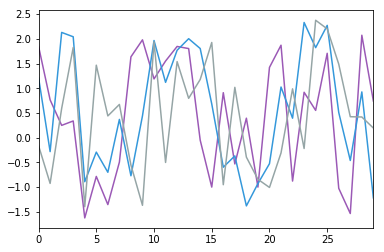

In [127]:
Y_arr_split_list = np.split(ary = Y_arr.flatten(), indices_or_sections = len(UNLABELED_CSV_COLUMNS), axis = 0)
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
for i, arr in enumerate(Y_arr_split_list):
    sns.tsplot(arr, color = flatui[i%len(flatui)] )

In [128]:
predictions_arr = np.array([[-0.17525467877662027, 0.05060534038341983, 0.08423866404095205]
, [-0.07473502082863288, 0.12577790412885864, -0.07915102038477133]
, [-0.12421062158134936, 0.06912123881936807, -0.011519947566918931]
, [-0.15664295811829942, 0.042538270827705775, -0.025789974616607123]
, [-0.15397790000652, 0.03908227476280727, -0.0251549018963263]
, [-0.15059776205711545, 0.04864294307050603, -0.025875672665069047]
, [-0.14581535945516522, 0.0601968041453678, -0.02749126003788888]
, [-0.143369853206751, 0.06841275382913925, -0.029320600465341712]
, [-0.14207337614593013, 0.07360649651778056, -0.030333748998440182]
, [-0.13976575811432274, 0.07532671870476418, -0.03078387195617836]
, [-0.13737180749955957, 0.07489529112152071, -0.03129799600305499]
, [-0.1353514588827302, 0.07358889201989949, -0.030788787003311512]
, [-0.13304850039520016, 0.07253625409906603, -0.03082335442551515]
, [-0.13067923772775814, 0.0718305638039079, -0.03108320539778212]
, [-0.12834783945219463, 0.07122071807743108, -0.030776915587231203]
, [-0.12587566782989462, 0.07024267069636414, -0.03035282021360599]
, [-0.12351034535771181, 0.06943845760865666, -0.02977314910206073]
, [-0.12115386595684356, 0.06894921518491035, -0.02879171504350834]
, [-0.11906570369953061, 0.06855436036233759, -0.027770867731801558]
, [-0.11720829658065342, 0.0682712756764115, -0.026772499310556835]
, [-0.115610671362962, 0.06800436903215645, -0.025925326630435574]
, [-0.11431456049391127, 0.06774944219696863, -0.025185287953462684]
, [-0.11324070413446967, 0.06750213521772133, -0.024572763006304947]
, [-0.11235813090420714, 0.06727855902102634, -0.024066232620059268]
, [-0.11164385621706106, 0.06708488341707405, -0.023645561675872284]
, [-0.1110761826100871, 0.06691008228837797, -0.02328940403427646]
, [-0.11060925777673804, 0.066770281331505, -0.022997553971059063]
, [-0.11022233236274358, 0.06666402614230385, -0.022755265808318537]
, [-0.10990113300409309, 0.06658588905178073, -0.02255183458584665]
, [-0.10963139610619167, 0.06652952615665186, -0.022377536705421735]
]
)
predictions_arr.shape

(30, 3)

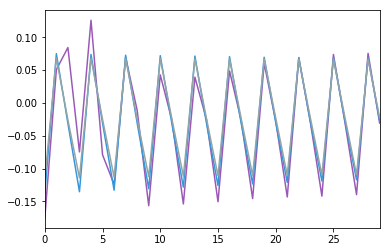

In [129]:
predictions_arr_split_list = np.split(ary = predictions_arr.flatten(), indices_or_sections = len(UNLABELED_CSV_COLUMNS), axis = 0)
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
for i, arr in enumerate(predictions_split_list):
    sns.tsplot(arr, color = flatui[i%len(flatui)] )

In [130]:
error_arr = np.array([[2.02240447877662, 0.7131247796165802, 0.16310155595904796]
, [0.4111518408286329, -1.7529918041288588, -0.7076195696152288]
, [-1.2329060584186506, -0.5668491988193681, 1.646729977566919]
, [2.1363220981182995, 1.1453606491722943, 1.576275644616607]
, [1.99965726000652, 1.7636959152371927, -0.027216458103673697]
, [-0.8522073779428845, 0.860718996929494, -0.5082283573349309]
, [0.5386707094551653, -1.0630534741453677, 1.448631950037889]
, [2.014152993206751, -0.9493123238291392, 0.9467988404653417]
, [0.6930147961459301, 1.6331271934822196, -0.9971117010015599]
, [-1.3981581918856771, 1.9976301712952358, 0.7709683819561783]
, [1.3493365874995595, -0.3590518311215207, 2.161248346003055]
, [2.17719052888273, -0.9674649320198995, -0.2638053329966885]
, [-0.5700217596047998, 0.295270205900934, -0.7425876955744848]
, [0.5711105577277582, 1.8940985361960923, 1.1496902853977822]
, [1.8972767694521946, 1.9315370219225687, 1.8346332255872313]
, [0.8072201478298946, -0.6702141406963641, -0.34050595978639403]
, [-1.2601391046422883, -1.0013681676086568, -0.4993041408979393]
, [1.1451811259568436, 0.3238159048150897, 2.3597536850435086]
, [1.9406369136995307, 2.2040160596376626, 0.5364261977318016]
, [-0.3464717734193466, 0.8564191643235886, -1.194273800689443]
, [-0.048625738637037993, -0.9964440590321565, 0.6163823366304355]
, [1.9385811304939113, -1.4682441621969686, 1.4914873479534627]
, [0.5516234441344696, 0.6034212747822787, -0.5328069569936951]
, [-1.2597548690957927, 1.8724239709789736, -0.4798265673799408]
, [1.650014756217061, 0.727987656582926, 1.2006072616758723]
, [2.037168592610087, -1.021432532288378, 1.0407873940342764]
, [-0.285367532223262, -0.911738001331505, -0.987062216028941]
, [-0.2012908576372564, 0.9207605438576961, -0.19835375419168144]
, [2.4864418030040927, 2.1350244509482197, 1.5107513245858466]
, [0.5323188961061917, 0.35031180384334815, 0.21538412670542173]
]
)
error_arr.shape

(30, 3)

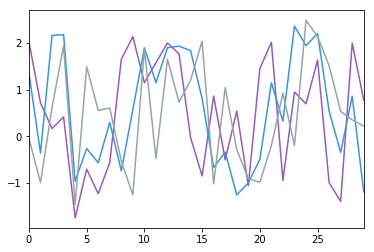

In [131]:
error_arr_split_list = np.split(ary = error_arr.flatten(), indices_or_sections = len(UNLABELED_CSV_COLUMNS), axis = 0)
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
for i, arr in enumerate(error_arr_split_list):
    sns.tsplot(arr, color = flatui[i%len(flatui)] )

In [132]:
absolute_error_arr = np.array([[2.02240447877662, 0.7131247796165802, 0.16310155595904796]
, [0.4111518408286329, 1.7529918041288588, 0.7076195696152288]
, [1.2329060584186506, 0.5668491988193681, 1.646729977566919]
, [2.1363220981182995, 1.1453606491722943, 1.576275644616607]
, [1.99965726000652, 1.7636959152371927, 0.027216458103673697]
, [0.8522073779428845, 0.860718996929494, 0.5082283573349309]
, [0.5386707094551653, 1.0630534741453677, 1.448631950037889]
, [2.014152993206751, 0.9493123238291392, 0.9467988404653417]
, [0.6930147961459301, 1.6331271934822196, 0.9971117010015599]
, [1.3981581918856771, 1.9976301712952358, 0.7709683819561783]
, [1.3493365874995595, 0.3590518311215207, 2.161248346003055]
, [2.17719052888273, 0.9674649320198995, 0.2638053329966885]
, [0.5700217596047998, 0.295270205900934, 0.7425876955744848]
, [0.5711105577277582, 1.8940985361960923, 1.1496902853977822]
, [1.8972767694521946, 1.9315370219225687, 1.8346332255872313]
, [0.8072201478298946, 0.6702141406963641, 0.34050595978639403]
, [1.2601391046422883, 1.0013681676086568, 0.4993041408979393]
, [1.1451811259568436, 0.3238159048150897, 2.3597536850435086]
, [1.9406369136995307, 2.2040160596376626, 0.5364261977318016]
, [0.3464717734193466, 0.8564191643235886, 1.194273800689443]
, [0.048625738637037993, 0.9964440590321565, 0.6163823366304355]
, [1.9385811304939113, 1.4682441621969686, 1.4914873479534627]
, [0.5516234441344696, 0.6034212747822787, 0.5328069569936951]
, [1.2597548690957927, 1.8724239709789736, 0.4798265673799408]
, [1.650014756217061, 0.727987656582926, 1.2006072616758723]
, [2.037168592610087, 1.021432532288378, 1.0407873940342764]
, [0.285367532223262, 0.911738001331505, 0.987062216028941]
, [0.2012908576372564, 0.9207605438576961, 0.19835375419168144]
, [2.4864418030040927, 2.1350244509482197, 1.5107513245858466]
, [0.5323188961061917, 0.35031180384334815, 0.21538412670542173]
]
)
absolute_error_arr.shape

(30, 3)

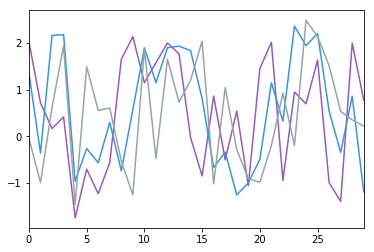

In [133]:
absolute_error_arr_split_list = np.split(ary = absolute_error_arr.flatten(), indices_or_sections = len(UNLABELED_CSV_COLUMNS), axis = 0)
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
for i, arr in enumerate(error_arr_split_list):
    sns.tsplot(arr, color = flatui[i%len(flatui)] )

#### Anomalous

In [147]:
with open('test_anomalous_sequences.json', 'w') as outfile:
    test_data_anomalous_string_list = [[np.array2string(a = create_time_series_with_anomaly(1, sequence_length, percent_sequence_before_anomaly, percent_sequence_after_anomaly, tag["normal_freq"], tag["normal_ampl"], tag["normal_noise_noise_scale"]), separator = ',').replace('[','').replace(']','').replace('\n','') for tag in tag_data_list] for _ in range(0, number_of_prediction_instances)]
    json_string = ""
    for item in test_data_anomalous_string_list:
        json_string += "{" + ','.join(["{0}: \"{1}\"".format('\"' + UNLABELED_CSV_COLUMNS[i] + '\"', item[i]) for i in range(0, len(UNLABELED_CSV_COLUMNS))]) + "}\n"
    json_string = json_string.replace(' ', '').replace(':', ': ').replace(',', ', ')
    outfile.write("%s" % json_string)

In [135]:
%%bash
model_dir=$(ls ${PWD}/trained_model/export/exporter | tail -1)
gcloud ml-engine local predict \
    --model-dir=${PWD}/trained_model/export/exporter/${model_dir} \
    --json-instances=./test_anomalous_sequences.json

Y                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

2019-03-28 15:33:15.096048: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2000185000 Hz
2019-03-28 15:33:15.107849: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x55fad9f20d60 executing computations on platform Host. Devices:
2019-03-28 15:33:15.107882: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>
2019-03-28 15:33:15.117844: I tensorflow/core/common_runtime/process_util.cc:71] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.

In [136]:
Y_arr = np.array([[-23.26710689, 3.4521628, -2.96271248]
, [-0.57202562, -7.36015567, -6.43586976]
, [-6.64458535, -9.08885506, -10.35835991]
, [8.304876, 7.99140141, 12.97762619]
, [20.40264988, 9.93218648, -3.14693377]
, [-5.79133593, -5.06420108, 3.42236717]
, [0.1577477, 13.31020776, -13.44650365]
, [16.83201618, -3.6842317, -7.28910068]
, [0.19641406, 10.553584, 7.73781923]
, [-0.83300731, 1.77362828, 0.18296079]
, [1.51910917, 0.29543142, 1.62892925]
, [1.35151674, -1.2103518, -0.34109723]
, [-0.66680325, -0.23649309, -0.42187621]
, [-0.1674966, 1.93565476, 1.23435409]
, [1.99900919, 2.10804904, 1.28601374]
, [0.12862085, -0.49427581, -0.60833114]
, [-1.43166286, -1.7100707, -0.57918935]
, [1.61692938, 0.07136756, 1.99649864]
, [1.44261511, 1.82504046, 1.17524807]
, [-1.1784663, 1.46050166, -0.8426445]
, [0.18147251, -0.47132675, 0.81615163]
, [1.94721461, -1.04543771, 1.86220282]
, [0.65191392, 0.71582116, 0.26202861]
, [-0.80296889, 2.11989805, -0.2963608]
, [1.75631024, 1.45510386, 1.99516959]
, [1.65095536, -0.65488954, 1.27934926]
, [-1.35838823, -0.48055829, -1.15316564]
, [0.245617, 1.78023864, 0.19347992]
, [2.50171169, 2.65218495, 2.06506546]
, [0.22732486, 0.11374566, 0.06010548]
]
)
Y_arr.shape

(30, 3)

/usr/local/lib/python3.5/dist-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


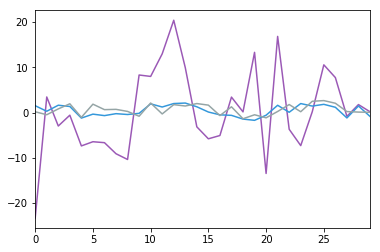

In [137]:
Y_arr_split_list = np.split(ary = Y_arr.flatten(), indices_or_sections = len(UNLABELED_CSV_COLUMNS), axis = 0)
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
for i, arr in enumerate(Y_arr_split_list):
    sns.tsplot(arr, color = flatui[i%len(flatui)] )

In [138]:
predictions_arr = np.array([[-0.18714140783621463, 0.05101352924692346, 0.08494981200746453]
, [-0.08168426696793239, 0.12948737764195686, -0.07665885568857553]
, [-0.1328566470691902, 0.0653471390387009, -0.011581725660560208]
, [-0.16222743241902587, 0.03852430686653465, -0.027428962413111487]
, [-0.1577770681416979, 0.03579668451035755, -0.027452877405907003]
, [-0.15284525892433365, 0.0460547047093502, -0.027889852123620922]
, [-0.1473795250686713, 0.05843975724771163, -0.0291811771761806]
, [-0.14432685576676918, 0.06731727491124428, -0.030657427773991254]
, [-0.1427603521807181, 0.07301684287045293, -0.03149795055157167]
, [-0.14042548248756143, 0.07505173861702605, -0.0316381204161282]
, [-0.13790563644247827, 0.07484850101640239, -0.032067207746820994]
, [-0.13587494219541202, 0.07360741747807162, -0.0314198288131433]
, [-0.13354237045443496, 0.07258224402601596, -0.0312566602634437]
, [-0.13113953181743832, 0.0718600420758308, -0.031473194382336735]
, [-0.12875538911104722, 0.07129173046181139, -0.031114181702607213]
, [-0.12628558558806607, 0.07031575414771413, -0.030650583024946047]
, [-0.12388201557786561, 0.06949682173159555, -0.030041173441564255]
, [-0.12150772588642629, 0.06897533703623257, -0.029058601158838987]
, [-0.11938340775999505, 0.06856157025432863, -0.028023469071761856]
, [-0.11749358464886257, 0.06827250695628939, -0.02699459624175395]
, [-0.11585205593049148, 0.06800480675942244, -0.026109748087318026]
, [-0.11452558968007089, 0.06774698911504518, -0.025352390771707447]
, [-0.11342482234739353, 0.06749849215601253, -0.024717962873939722]
, [-0.11251846995515032, 0.06727298934359746, -0.02419336991215214]
, [-0.11177977563181994, 0.06708014482260877, -0.023758500527954148]
, [-0.11119427462967908, 0.0669040259423816, -0.023387400490781217]
, [-0.11071241727518967, 0.06676301426472064, -0.023082710180752444]
, [-0.11031207503974215, 0.0666558623641973, -0.022829395042365676]
, [-0.10997947916016972, 0.06657728729441942, -0.022616614028969428]
, [-0.10970010481392985, 0.06652117546932343, -0.022434469952646845]
]
)
predictions_arr.shape

(30, 3)

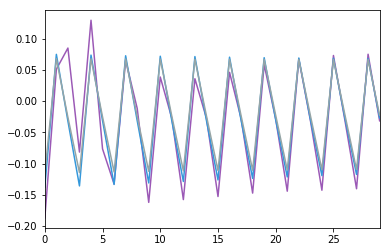

In [139]:
predictions_arr_split_list = np.split(ary = predictions_arr.flatten(), indices_or_sections = len(UNLABELED_CSV_COLUMNS), axis = 0)
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
for i, arr in enumerate(predictions_arr_split_list):
    sns.tsplot(arr, color = flatui[i%len(flatui)] )

In [140]:
error_arr = np.array([[-23.079965482163786, 3.4011492707530766, -3.0476622920074643]
, [-0.4903413530320676, -7.489643047641957, -6.359210904311425]
, [-6.511728702930809, -9.154202199038702, -10.34677818433944]
, [8.467103432419027, 7.952877103133465, 13.005055152413112]
, [20.560426948141696, 9.896389795489643, -3.119480892594093]
, [-5.638490671075666, -5.11025578470935, 3.450257022123621]
, [0.3051272250686713, 13.25176800275229, -13.41732247282382]
, [16.97634303576677, -3.7515489749112447, -7.258443252226009]
, [0.3391744121807181, 10.480567157129547, 7.769317180551572]
, [-0.6925818275124385, 1.698576541382974, 0.21459891041612822]
, [1.6570148064424781, 0.2205829189835976, 1.660996457746821]
, [1.487391682195412, -1.2839592174780716, -0.30967740118685666]
, [-0.533260879545565, -0.30907533402601595, -0.39061954973655627]
, [-0.03635706818256168, 1.8637947179241692, 1.2658272843823368]
, [2.127764579111047, 2.0367573095381886, 1.3171279217026073]
, [0.2549064355880661, -0.5645915641477142, -0.5776805569750539]
, [-1.3077808444221344, -1.7795675217315954, -0.5491481765584358]
, [1.7384371058864263, 0.0023922229637674264, 2.025557241158839]
, [1.561998517759995, 1.7564788897456713, 1.2032715390717619]
, [-1.0609727153511375, 1.3922291530437105, -0.8156499037582461]
, [0.2973245659304915, -0.5393315567594225, 0.842261378087318]
, [2.061740199680071, -1.1131846991150454, 1.8875552107717075]
, [0.7653387423473935, 0.6483226678439874, 0.28674657287393973]
, [-0.6904504200448497, 2.052625060656403, -0.27216743008784783]
, [1.8680900156318199, 1.388023715177391, 2.0189280905279543]
, [1.762149634629679, -0.7217935659423815, 1.3027366604907813]
, [-1.2476758127248104, -0.5473213042647207, -1.1300829298192476]
, [0.35592907503974214, 1.7135827776358028, 0.21630931504236567]
, [2.61169116916017, 2.5856076627055806, 2.0876820740289697]
, [0.33702496481392985, 0.04722448453067657, 0.08253994995264685]
]
)
error_arr.shape

(30, 3)

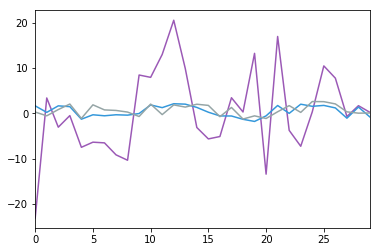

In [141]:
error_arr_split_list = np.split(ary = error_arr.flatten(), indices_or_sections = len(UNLABELED_CSV_COLUMNS), axis = 0)
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
for i, arr in enumerate(error_arr_split_list):
    sns.tsplot(arr, color = flatui[i%len(flatui)] )

In [142]:
absolute_error_arr = np.array([[23.079965482163786, 3.4011492707530766, 3.0476622920074643]
, [0.4903413530320676, 7.489643047641957, 6.359210904311425]
, [6.511728702930809, 9.154202199038702, 10.34677818433944]
, [8.467103432419027, 7.952877103133465, 13.005055152413112]
, [20.560426948141696, 9.896389795489643, 3.119480892594093]
, [5.638490671075666, 5.11025578470935, 3.450257022123621]
, [0.3051272250686713, 13.25176800275229, 13.41732247282382]
, [16.97634303576677, 3.7515489749112447, 7.258443252226009]
, [0.3391744121807181, 10.480567157129547, 7.769317180551572]
, [0.6925818275124385, 1.698576541382974, 0.21459891041612822]
, [1.6570148064424781, 0.2205829189835976, 1.660996457746821]
, [1.487391682195412, 1.2839592174780716, 0.30967740118685666]
, [0.533260879545565, 0.30907533402601595, 0.39061954973655627]
, [0.03635706818256168, 1.8637947179241692, 1.2658272843823368]
, [2.127764579111047, 2.0367573095381886, 1.3171279217026073]
, [0.2549064355880661, 0.5645915641477142, 0.5776805569750539]
, [1.3077808444221344, 1.7795675217315954, 0.5491481765584358]
, [1.7384371058864263, 0.0023922229637674264, 2.025557241158839]
, [1.561998517759995, 1.7564788897456713, 1.2032715390717619]
, [1.0609727153511375, 1.3922291530437105, 0.8156499037582461]
, [0.2973245659304915, 0.5393315567594225, 0.842261378087318]
, [2.061740199680071, 1.1131846991150454, 1.8875552107717075]
, [0.7653387423473935, 0.6483226678439874, 0.28674657287393973]
, [0.6904504200448497, 2.052625060656403, 0.27216743008784783]
, [1.8680900156318199, 1.388023715177391, 2.0189280905279543]
, [1.762149634629679, 0.7217935659423815, 1.3027366604907813]
, [1.2476758127248104, 0.5473213042647207, 1.1300829298192476]
, [0.35592907503974214, 1.7135827776358028, 0.21630931504236567]
, [2.61169116916017, 2.5856076627055806, 2.0876820740289697]
, [0.33702496481392985, 0.04722448453067657, 0.08253994995264685]
]
)
absolute_error_arr.shape

(30, 3)

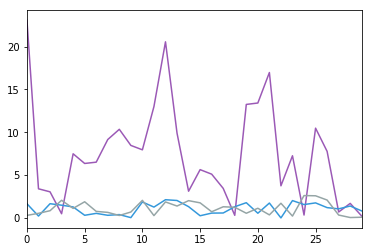

In [143]:
absolute_error_arr_split_list = np.split(ary = absolute_error_arr.flatten(), indices_or_sections = len(UNLABELED_CSV_COLUMNS), axis = 0)
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
for i, arr in enumerate(absolute_error_arr_split_list):
    sns.tsplot(arr, color = flatui[i%len(flatui)] )

### GCloud ML-Engine prediction from deployed model

In [ ]:
# Format dataframe to instances list to get sent to ML-Engine
instances = [{column: np.array2string(a = create_time_series_with_anomaly(1, sequence_length, percent_sequence_before_anomaly, percent_sequence_after_anomaly, tag["clean_freq"], tag["clean_ampl"], tag["clean_noise_noise_scale"]), separator = ',').replace('[','').replace(']','').replace('\n','') for tag in tag_data_list for column in CSV_COLUMNS} for _ in range(0, number_of_prediction_instances)]

In [ ]:
# Send instance dictionary to receive response from ML-Engine for online prediction
from googleapiclient import discovery
from oauth2client.client import GoogleCredentials
import json

credentials = GoogleCredentials.get_application_default()
api = discovery.build('ml', 'v1', credentials=credentials)

request_data = {"instances": instances}

parent = 'projects/%s/models/%s/versions/%s' % (PROJECT, 'lstm_autoencoder_anomaly_detection', 'v1')
response = api.projects().predict(body = request_data, name = parent).execute()
print("response = {}".format(response))

In [42]:
!cp -r ../../../../tutorials/machine_learning_deepdive/06_structured/babyweight/* lstm_encoder_decoder_autoencoder_anomaly_detection_module/

In [41]:
!ls

data
lstm_encoder_decoder_autoencoder_anomaly_detection.ipynb
lstm_encoder_decoder_autoencoder_anomaly_detection_module
tf_mahalanobis_test.ipynb
trained_model


In [43]:
!ls lstm_encoder_decoder_autoencoder_anomaly_detection_module

PKG-INFO  setup.cfg  setup.py  trainer
